In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

input_size=784
output_size=784
font = {'size'   : 20}
plt.rc('font', **font)
torch.set_default_dtype(torch.float64)
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size,h_size,xinit=[],xfinal=[]):
            
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.h_size=h_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2=torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(self.hidden_size, 10)
            self.sigmoid = torch.nn.Sigmoid()
            self.xinit=xinit
            self.xfinal=xfinal
        def forward(self, x):
            
            fc1 = self.fc1(x)
    
            x = self.relu(fc1)
            self.xinit=x
            #for layer in range(self.h_size):
             #   x = F.relu(self.fc2(x))
            x=Feedforward.internals(self,x)
            self.xfinal=x
            output = self.fc3(x)
            output = F.log_softmax(output,dim=1)
            return output
        def internals(self,x):
            for layer in range(self.h_size):
                x = F.relu(self.fc2(x))
            return x
        #def encoder(self,x):
            #return
        #def decoder(self,x):
        #    return
        
        def init(self):
            return self.xinit
        def final(self):
            
            return self.xfinal

In [9]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100,shuffle=False)

In [10]:
def add_noise(inputs,strength):
    
    noise = torch.randn_like(inputs)*strength
    return inputs + noise
def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1)
            input_image=add_noise(batch_features,noise_strength).view(batch_size, -1)
            batch_feature = batch_features.view(batch_size, -1)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)/256

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs
    for i in range(no_of_repetition):
        x_train=y_pred
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    for j in range(no_of_repetition):

        x_train=initial_input
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian

def spectral_radius(model,initial_input,no_of_repetition,no_of_images):
    result=[]
   
    output=initial_input
    product=torch.eye(n=input_size,m=output_size)
    
    spectral=0

    for i in range(no_of_repetition):
        
        res=torch.autograd.functional.jacobian(model.internals,initial_input)
        product=torch.matmul(product,res)
        output=model(initial_input)
        initial_input=output
    
    s,v=torch.linalg.eig(product)
    #print(s)
    abs=torch.abs(s)
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model.internals(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=Feedforward(784,784,2)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))

    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    ave_jac = asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
   
    average_jacobian.append(ave_jac)
    
    #for i in range(no_of_images):
    
        #spectral+=spectral_radius(model_clone,x_train[i],no_of_repetition,no_of_images)
    
   # spectral_radiuses.append(spectral/no_of_images)
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs
    y_pred_perturbed=perturbed_inputs
    
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
    divergent=0

    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model.internals(x_train_perturbed)
        
        diff=0        
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
  
            diff+=result
            if result>cutoff and i==no_of_repetition-1:
                chaos+=1
            
        distance.append(diff.detach().numpy()/no_of_image)
        #print(diff.detach().numpy())
    return distance,hidden_layer,chaos/no_of_image,divergent

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(28,28), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

In [11]:
import matplotlib.pyplot as plt 
epochs=100
asymptotic_repetition=200


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,100
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-10)
noise_strength=10**(-3)
interval=20

here
epoch: 1 Train loss:0.48091344 train accuracy:81.150%,test accuracy:84.240000%
percentage of chaos: 0.0
percentage of convergent: 0.0
0.0


/tmp/ipykernel_6932/1436160901.py:97: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


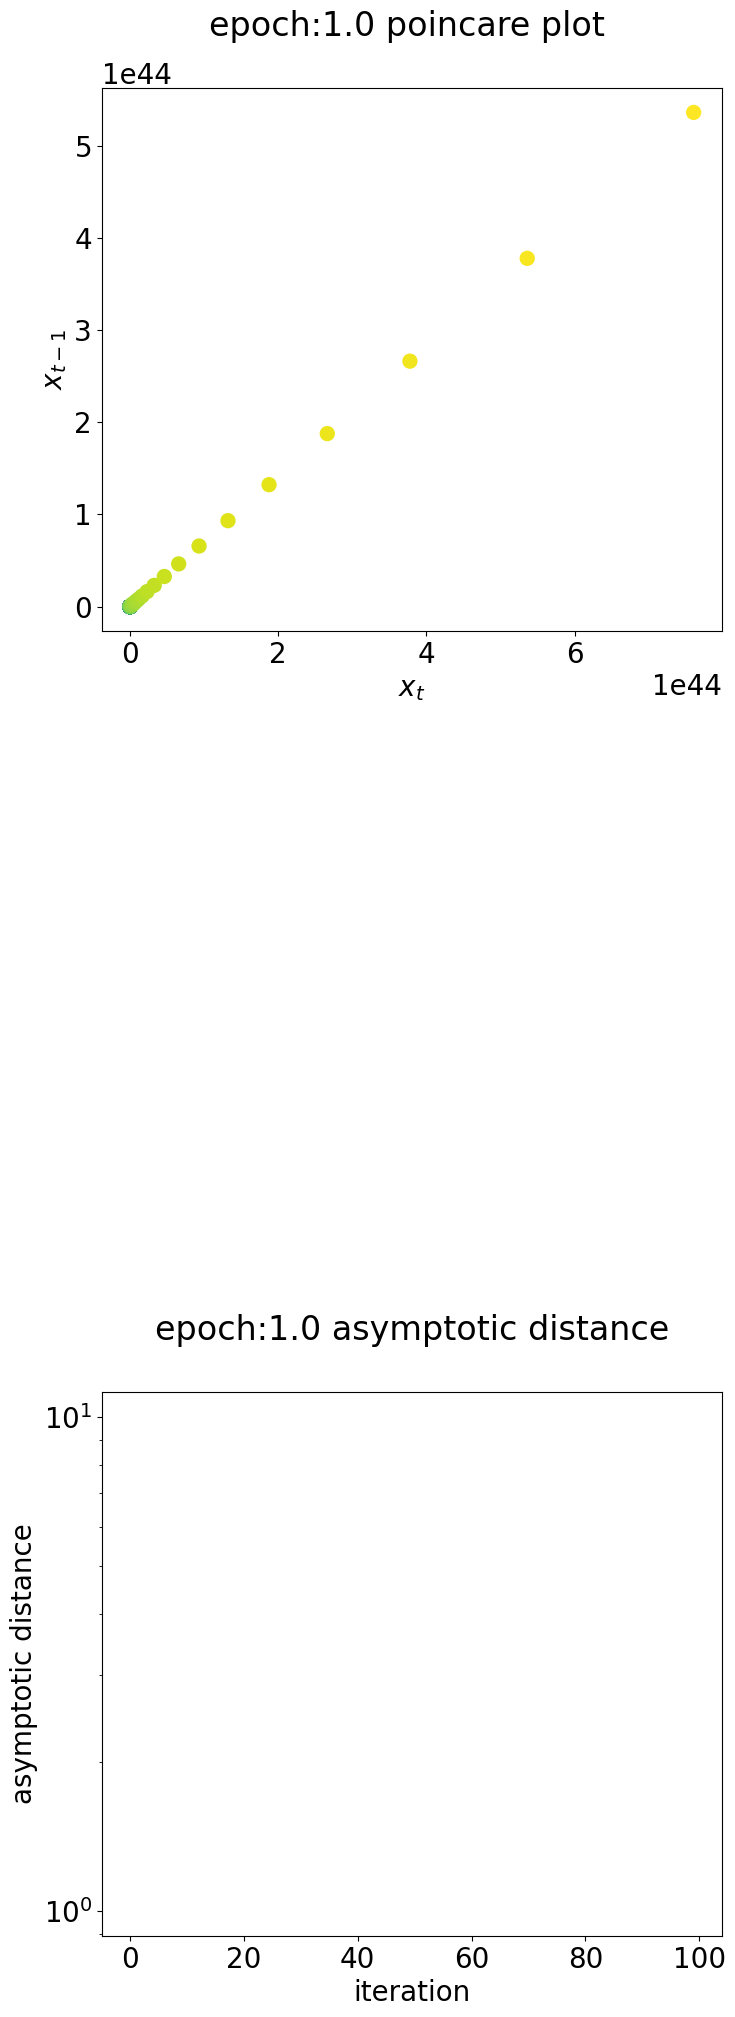

epoch: 2 Train loss:0.43775087 train accuracy:86.615%,test accuracy:86.830000%
percentage of chaos: 0.0
percentage of convergent: 0.0
1.6288574659091694e-09


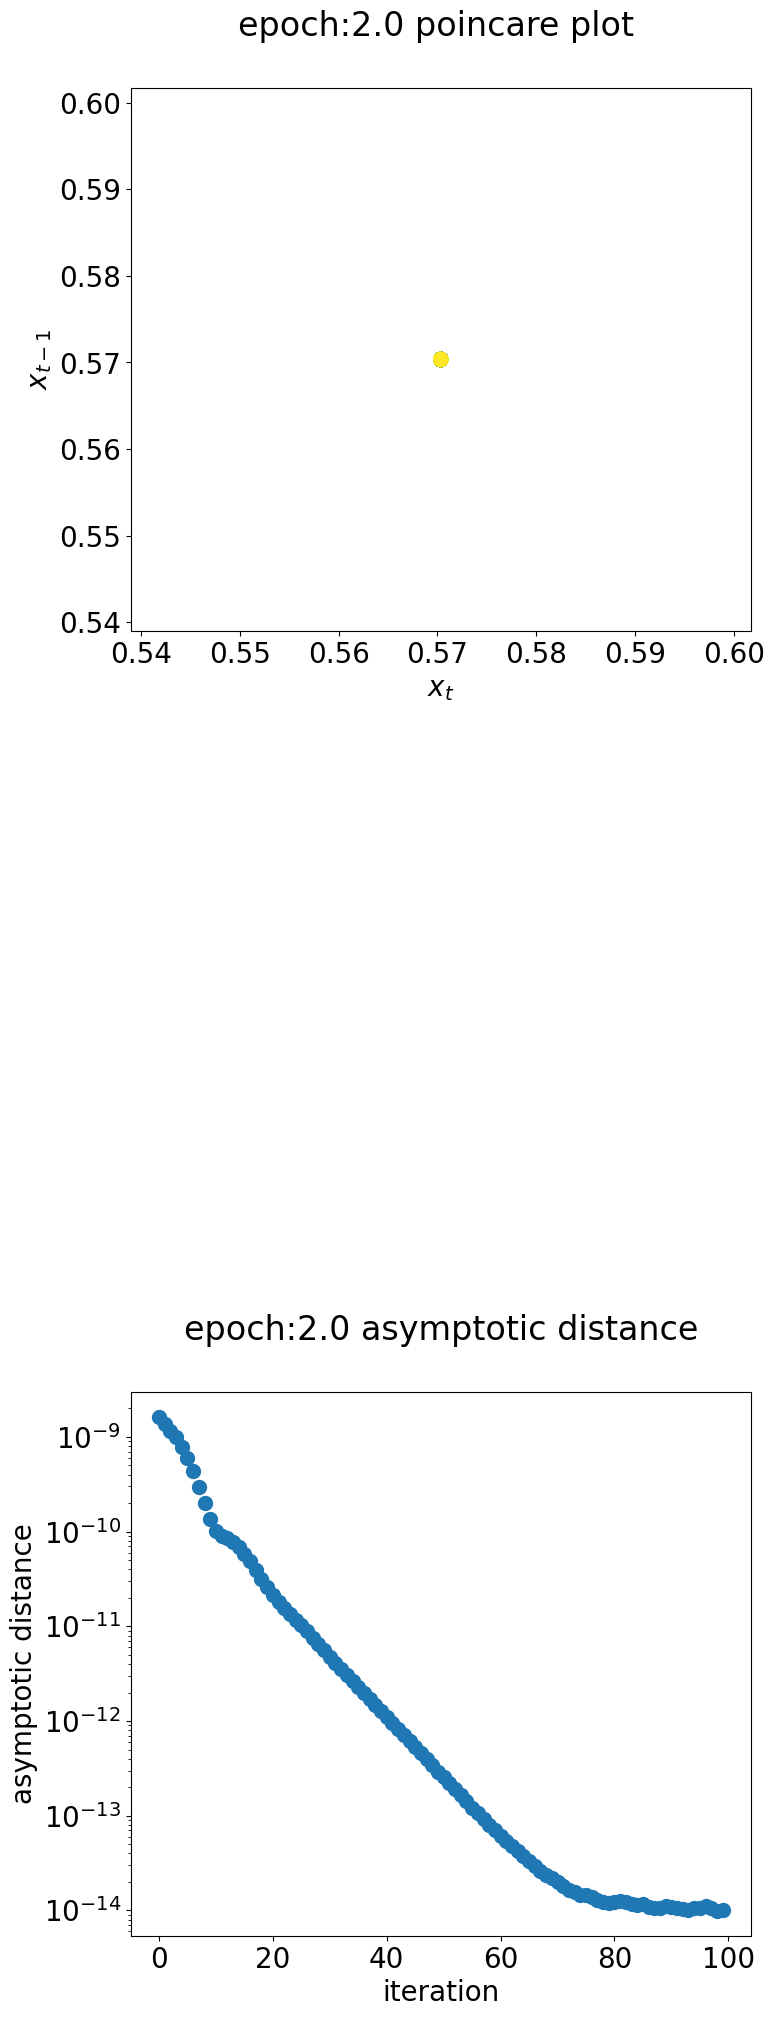

epoch: 3 Train loss:0.43591670 train accuracy:87.927%,test accuracy:85.900000%
percentage of chaos: 0.0
percentage of convergent: 0.0
1.6546528329115706e-09


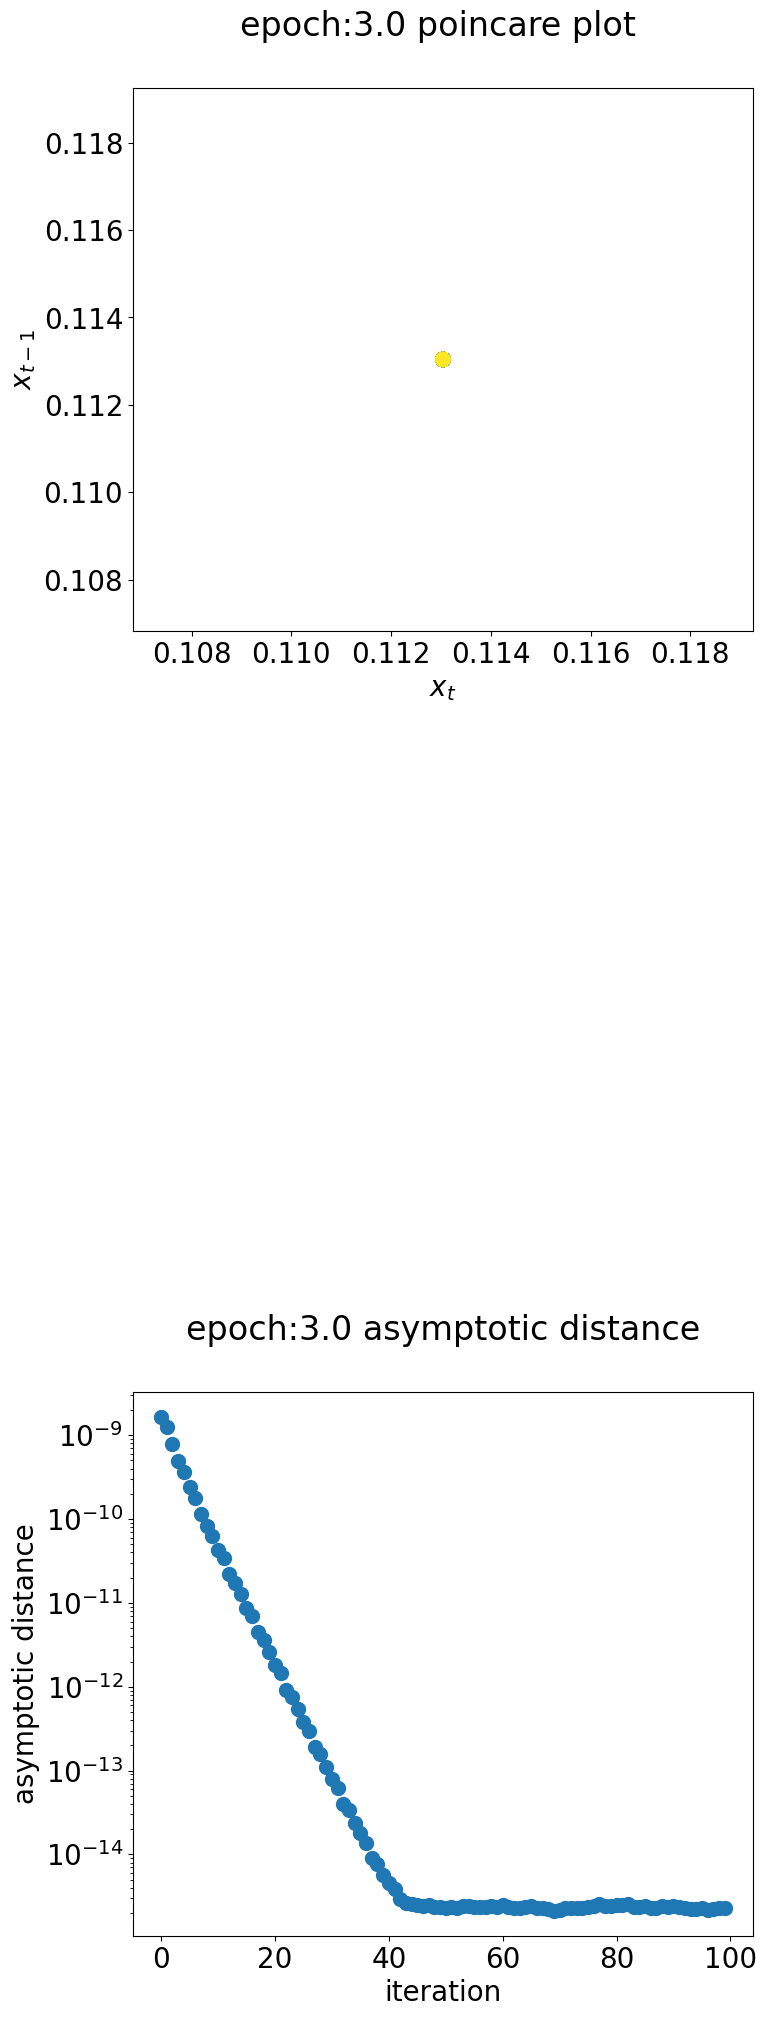

epoch: 4 Train loss:0.48595963 train accuracy:88.718%,test accuracy:86.630000%
percentage of chaos: 0.0
percentage of convergent: 0.0
1.7267386942700808e-09


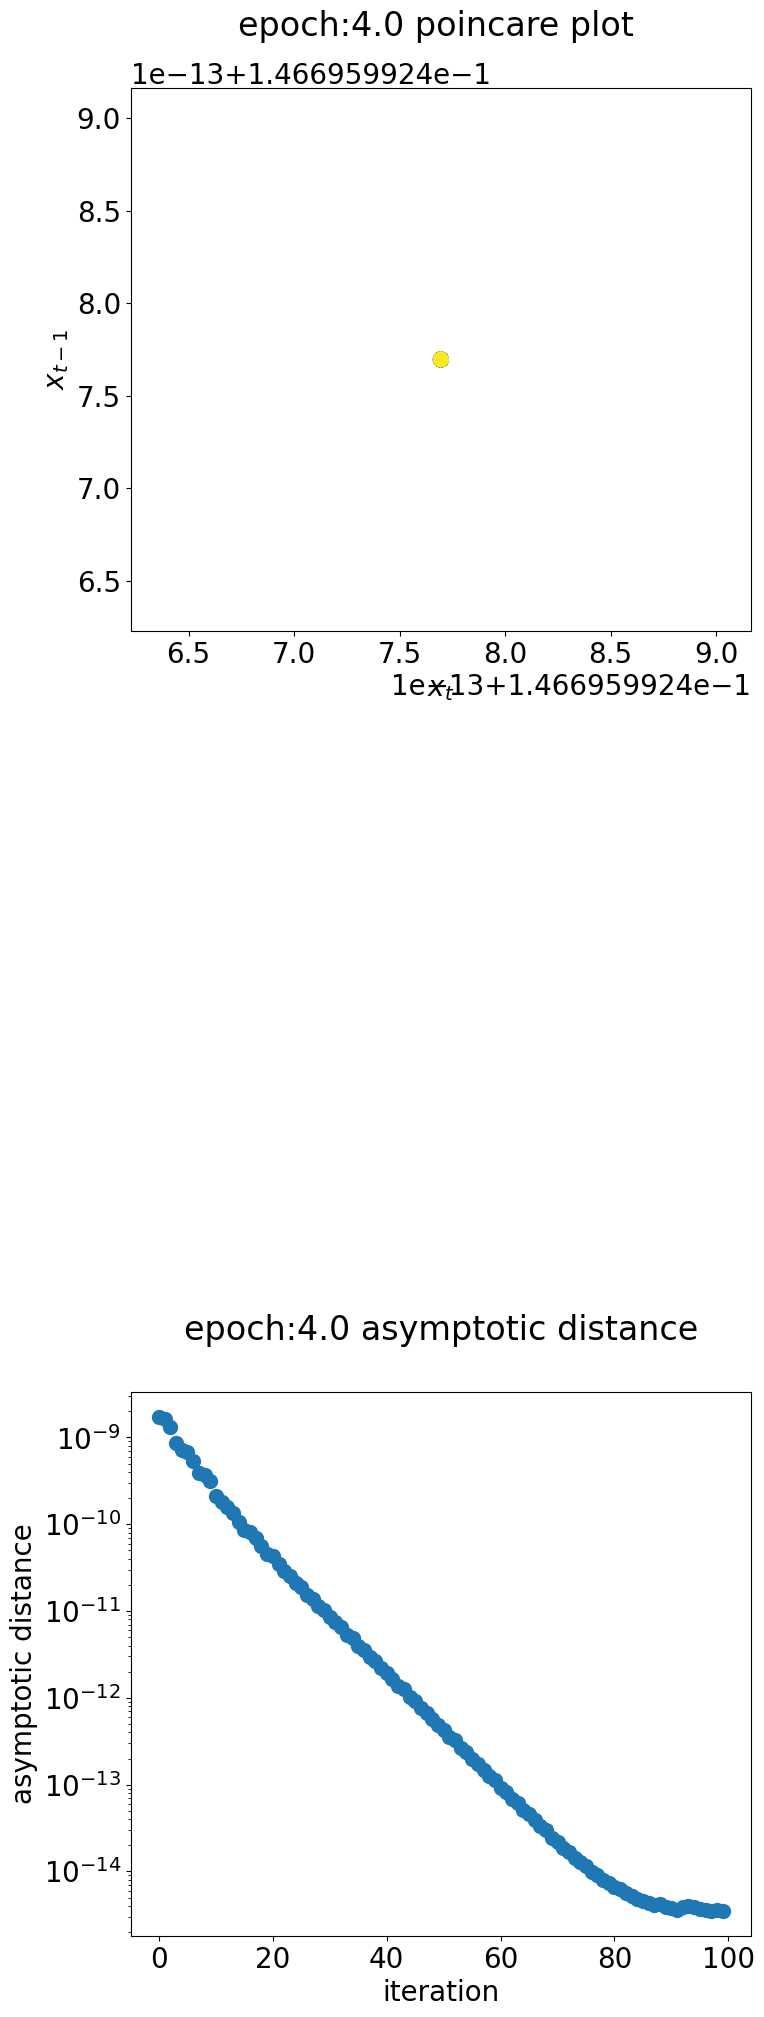

epoch: 5 Train loss:0.37208343 train accuracy:89.445%,test accuracy:87.720000%
percentage of chaos: 0.0
percentage of convergent: 0.0
2.1268879390790715e-09


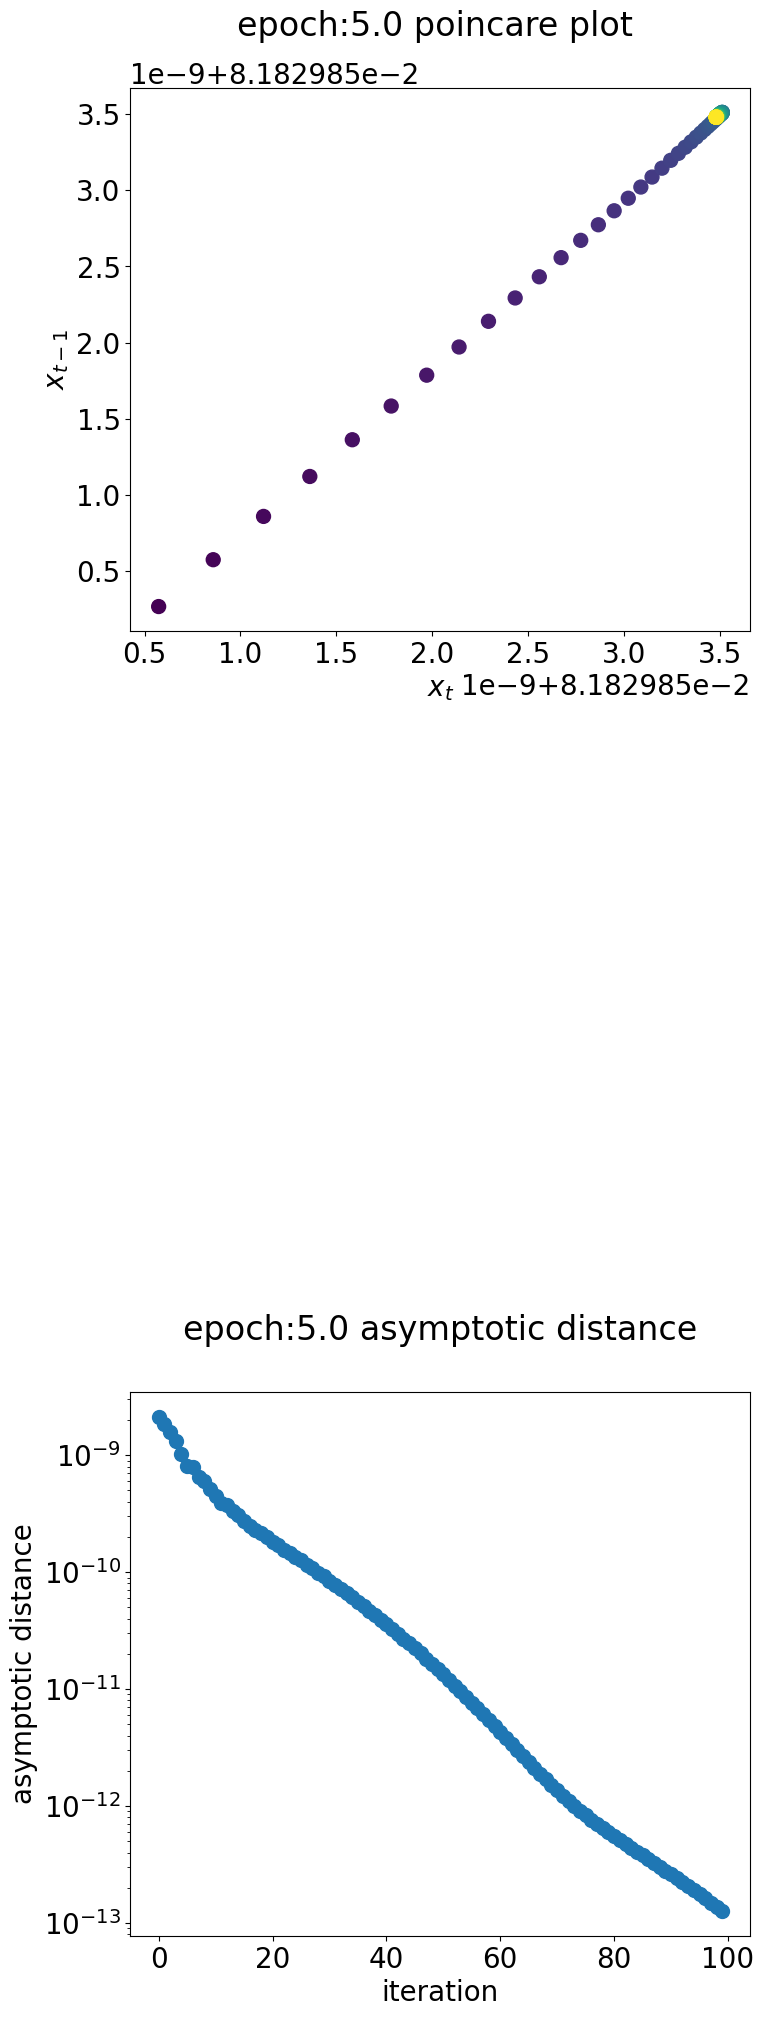

epoch: 6 Train loss:0.35212615 train accuracy:89.813%,test accuracy:87.840000%
percentage of chaos: 0.0
percentage of convergent: 0.0
1.9421267385194804e-09


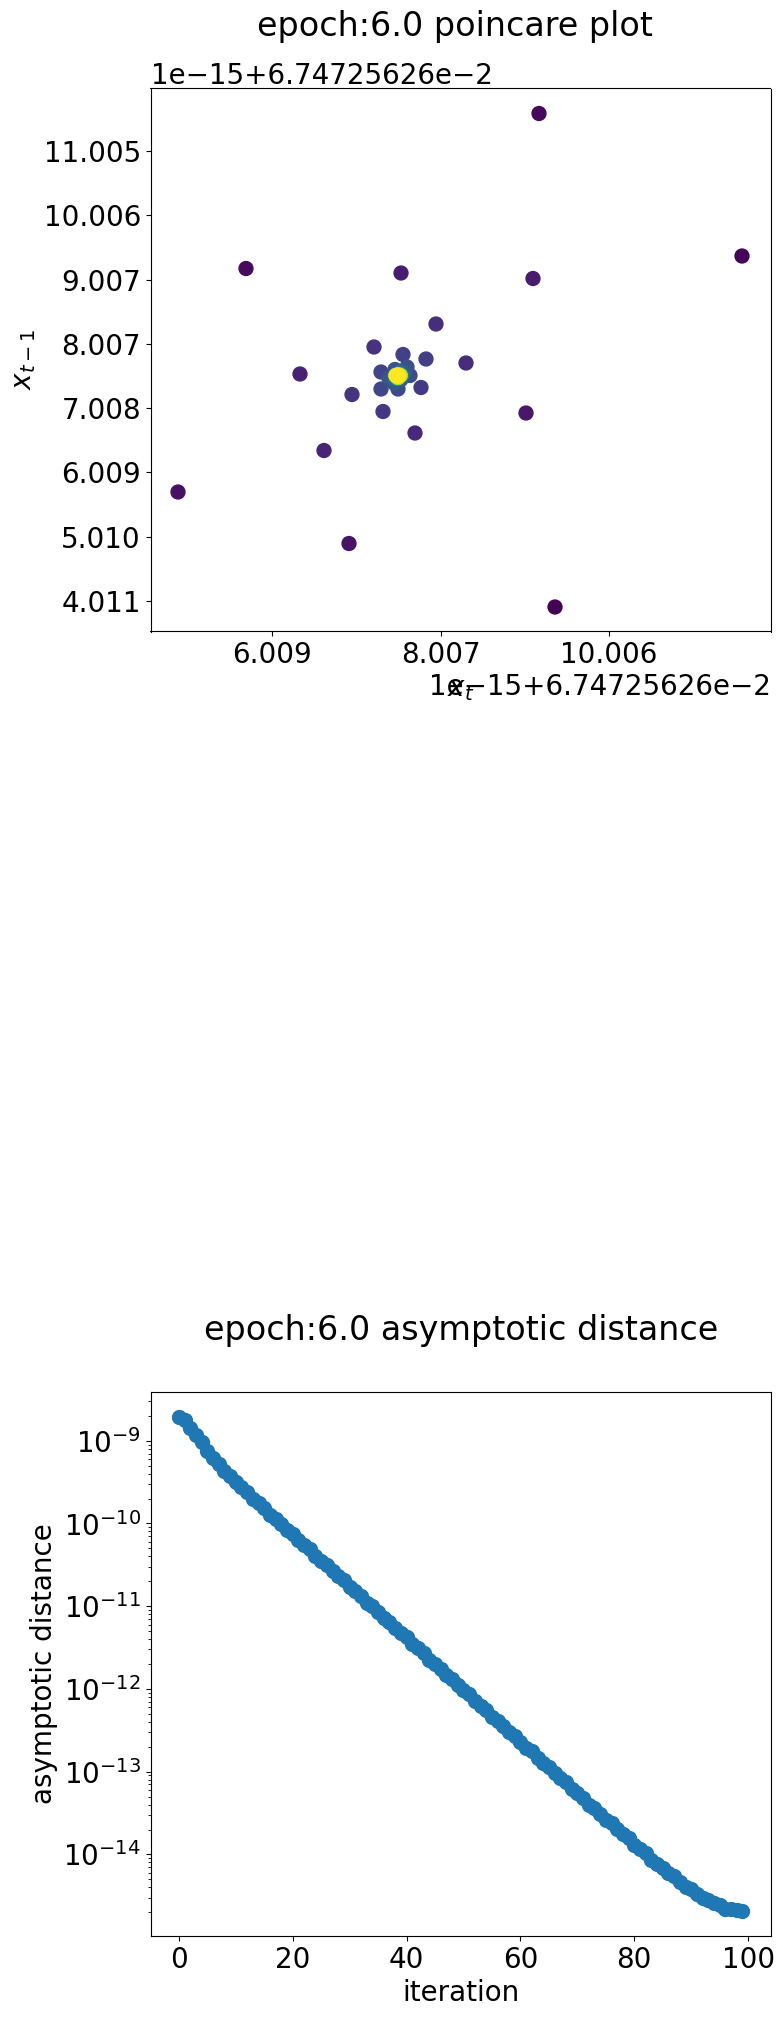

epoch: 7 Train loss:0.30774912 train accuracy:90.435%,test accuracy:88.280000%
percentage of chaos: 0.0
percentage of convergent: 0.0
2.2164974264222634e-09


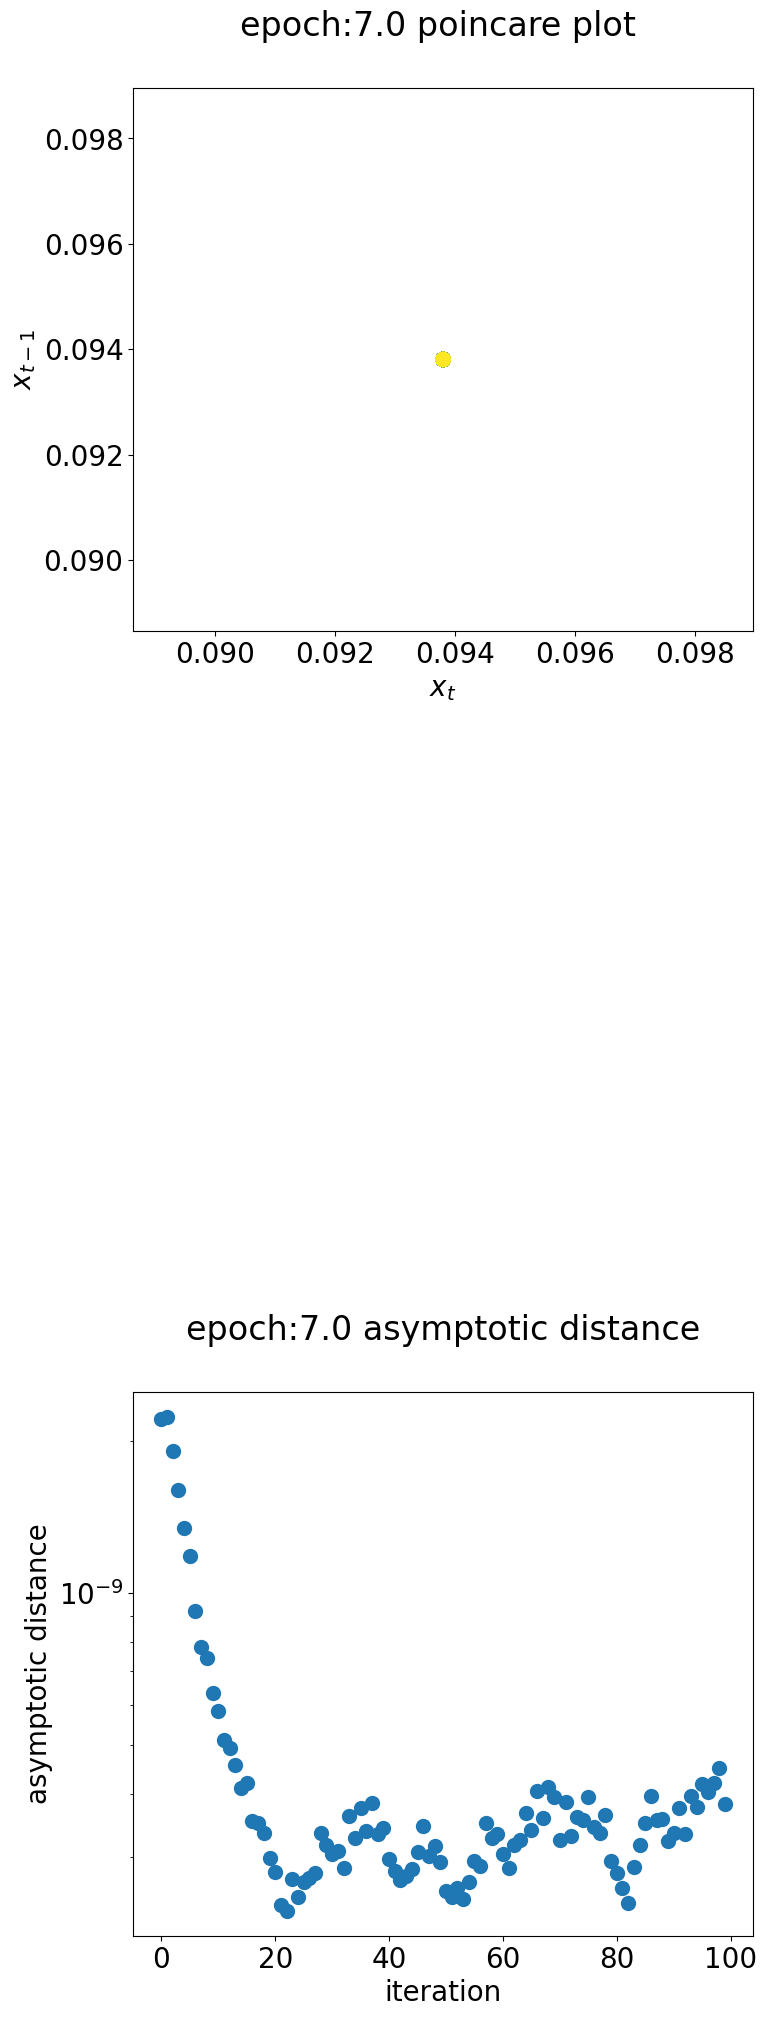

epoch: 8 Train loss:0.28238662 train accuracy:90.943%,test accuracy:88.310000%
percentage of chaos: 0.0
percentage of convergent: 0.0
2.165956608282233e-09


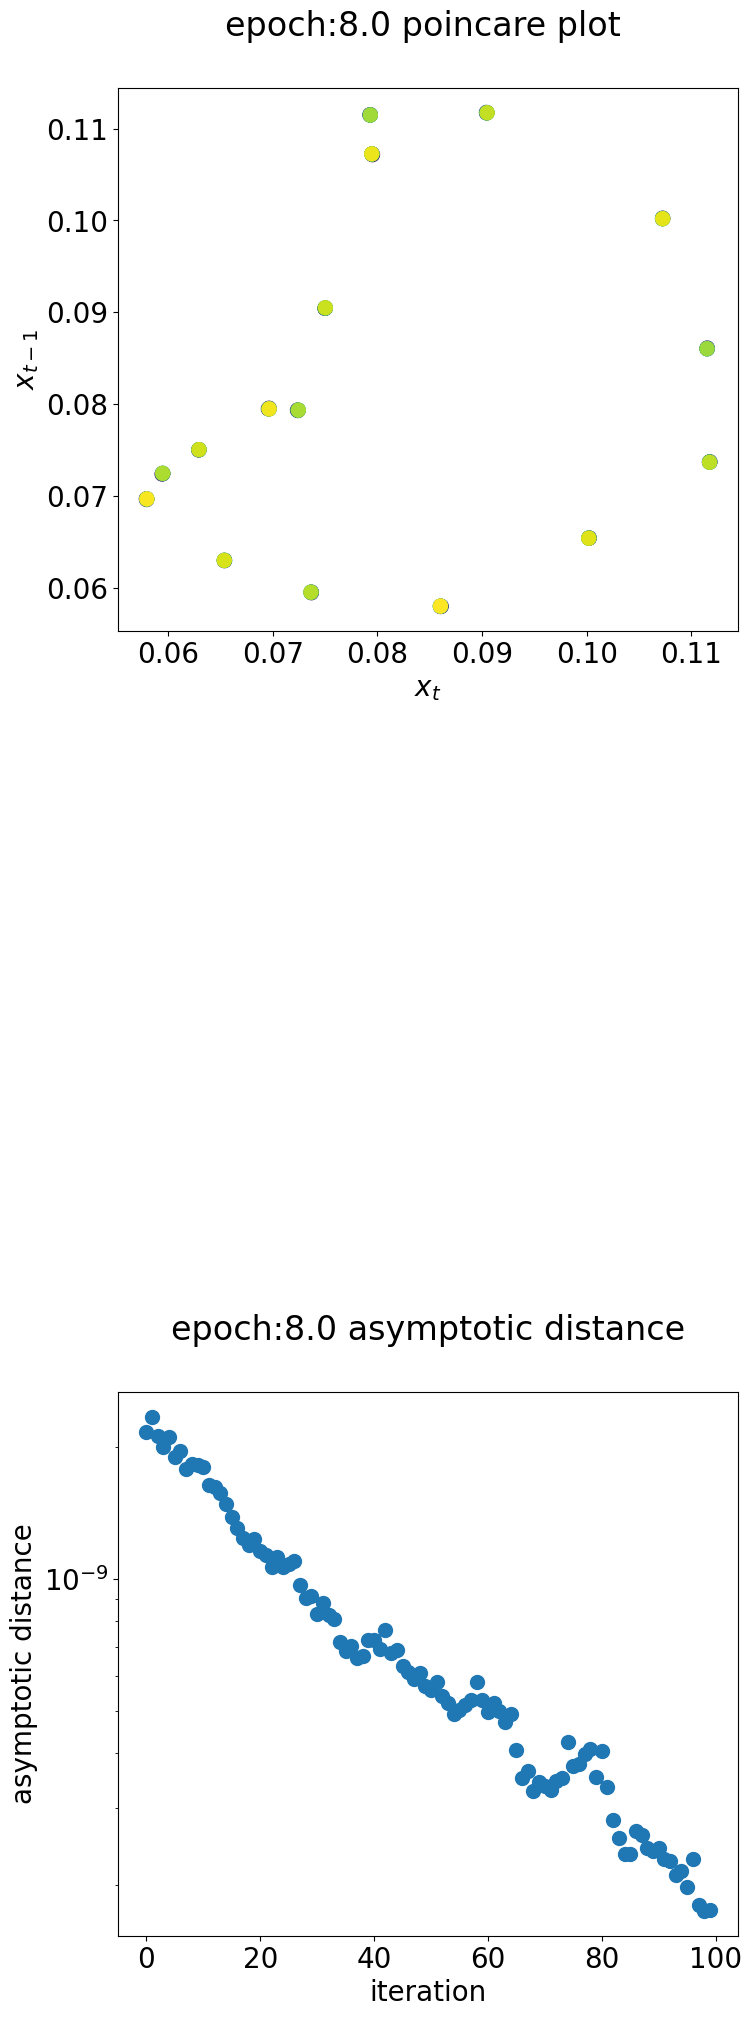

epoch: 9 Train loss:0.31130625 train accuracy:91.297%,test accuracy:88.610000%
percentage of chaos: 0.0
percentage of convergent: 0.0
2.071208723533643e-09


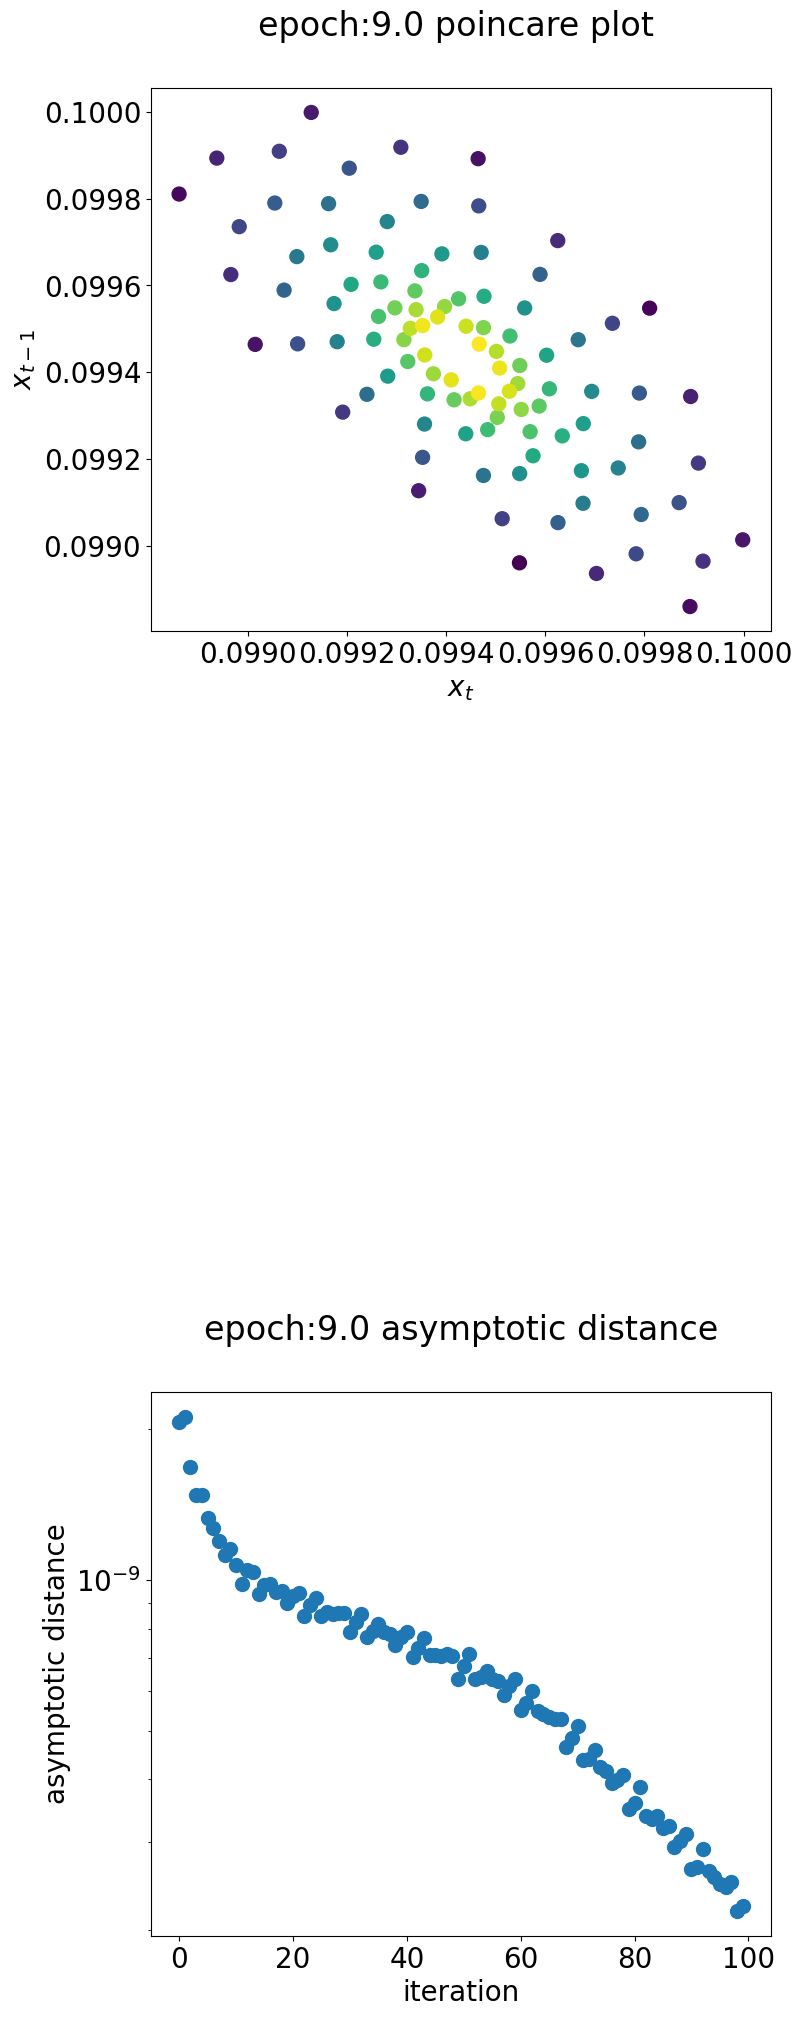

epoch:10 Train loss:0.31277949 train accuracy:91.643%,test accuracy:88.580000%
percentage of chaos: 0.1
percentage of convergent: 0.0
2.4403125187465384e-09


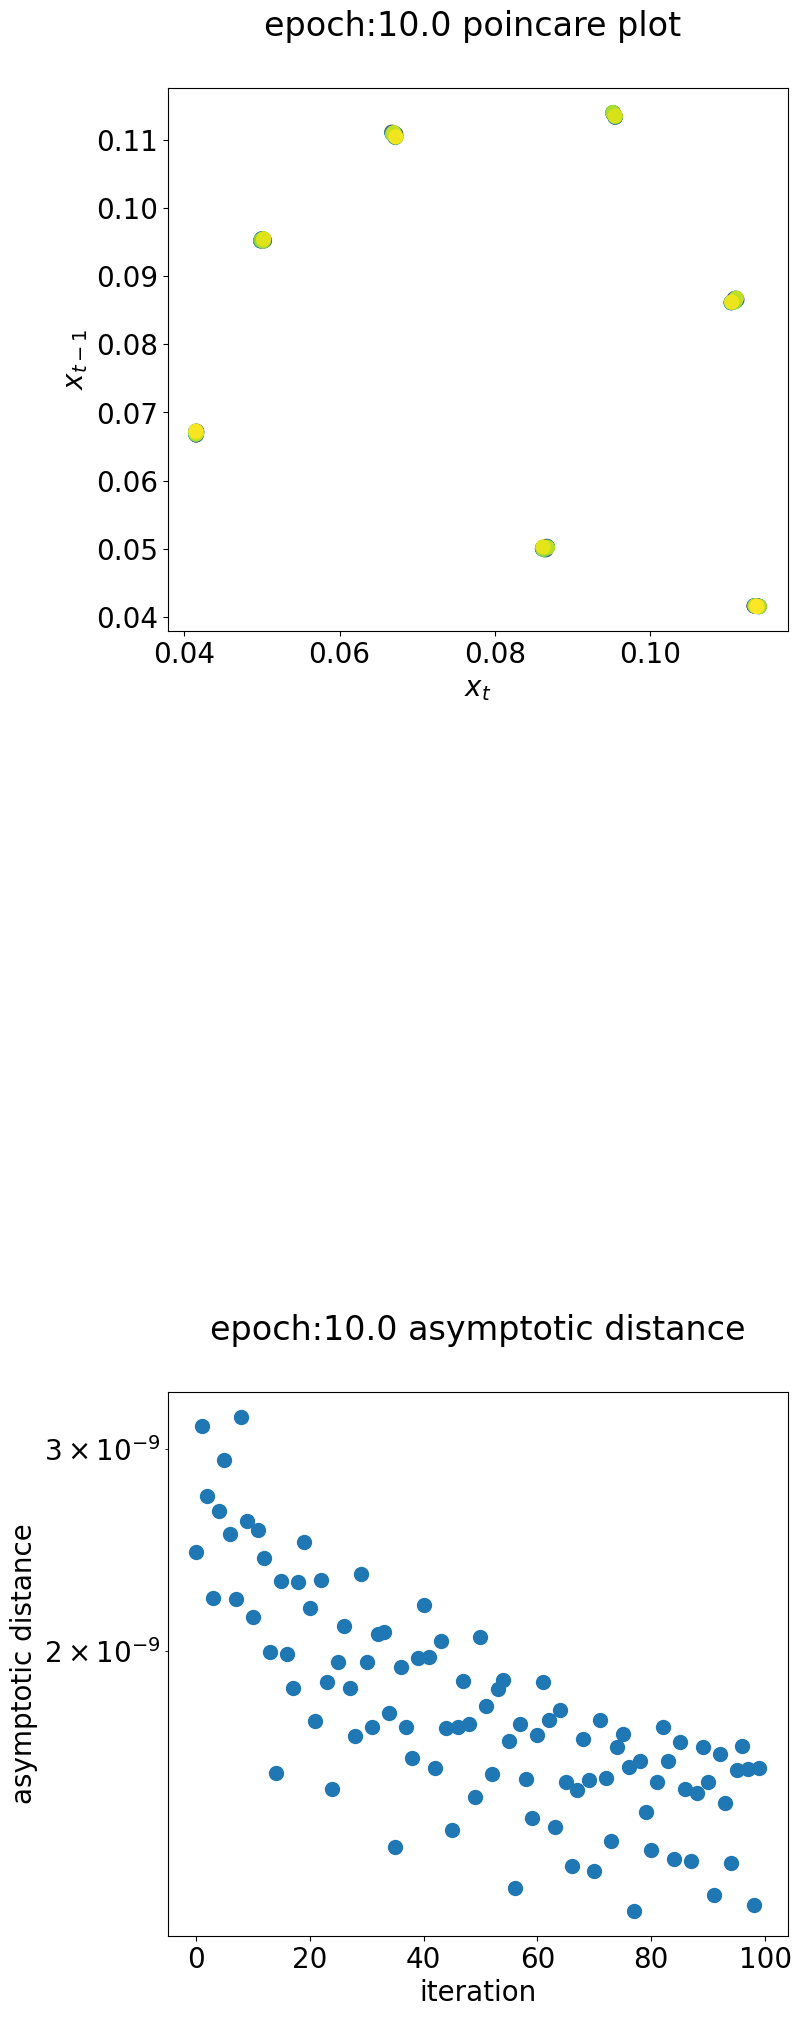

epoch:11 Train loss:0.32884428 train accuracy:91.947%,test accuracy:88.990000%
percentage of chaos: 0.95
percentage of convergent: 0.0
3.504889308745326e-09


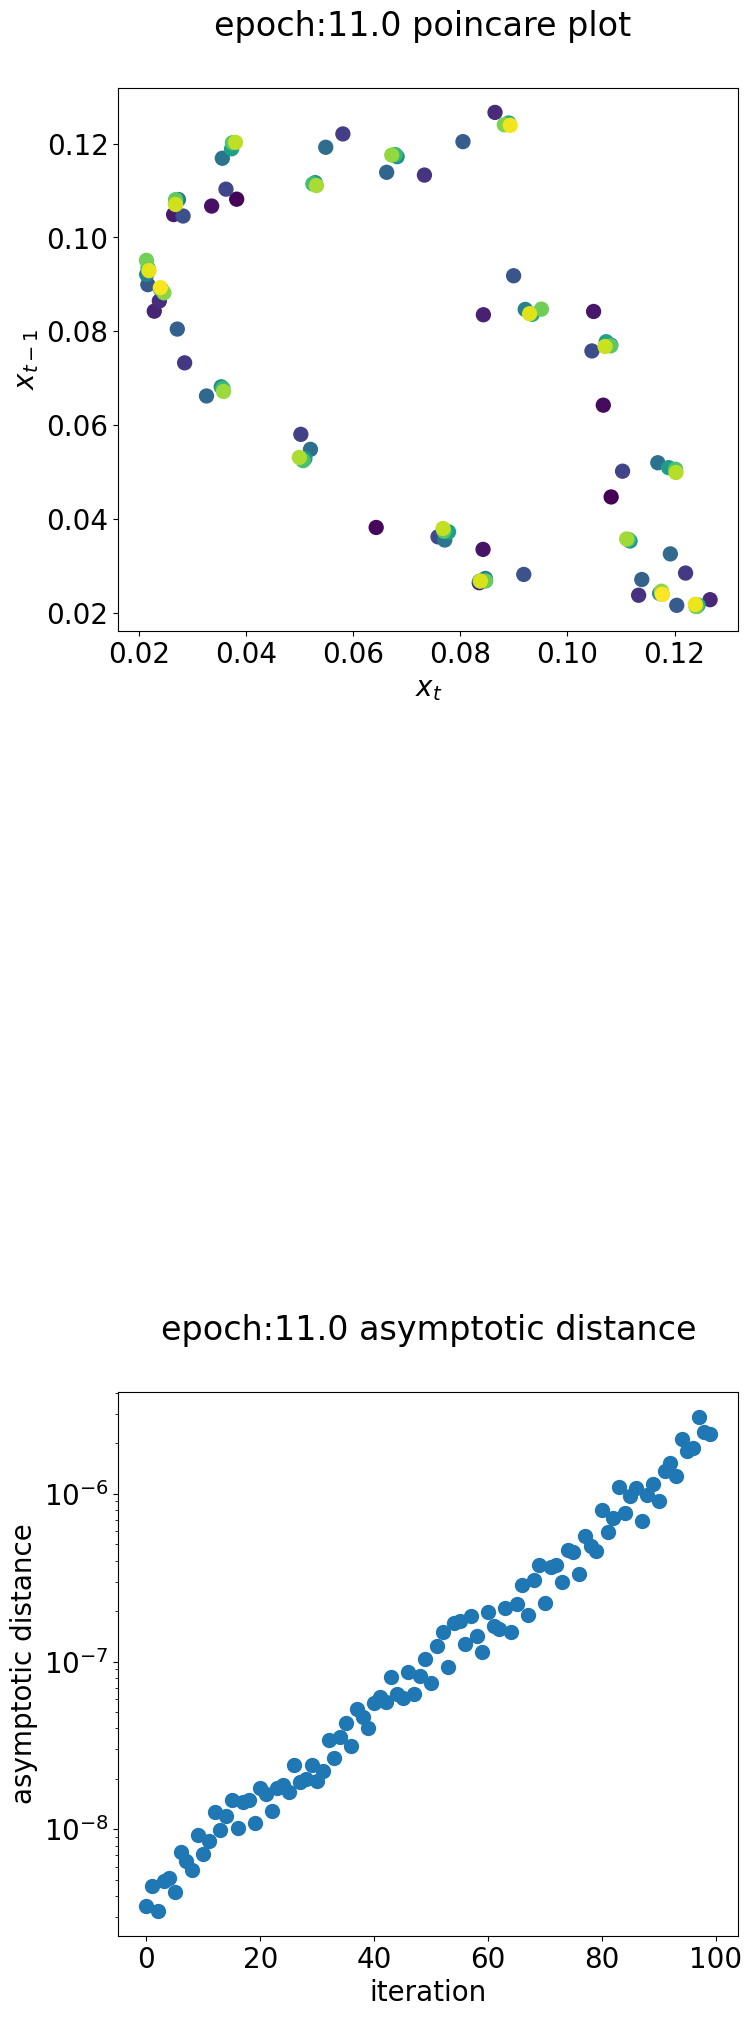

epoch:12 Train loss:0.28791954 train accuracy:92.252%,test accuracy:89.350000%
percentage of chaos: 1.0
percentage of convergent: 0.0
2.755181588529815e-09


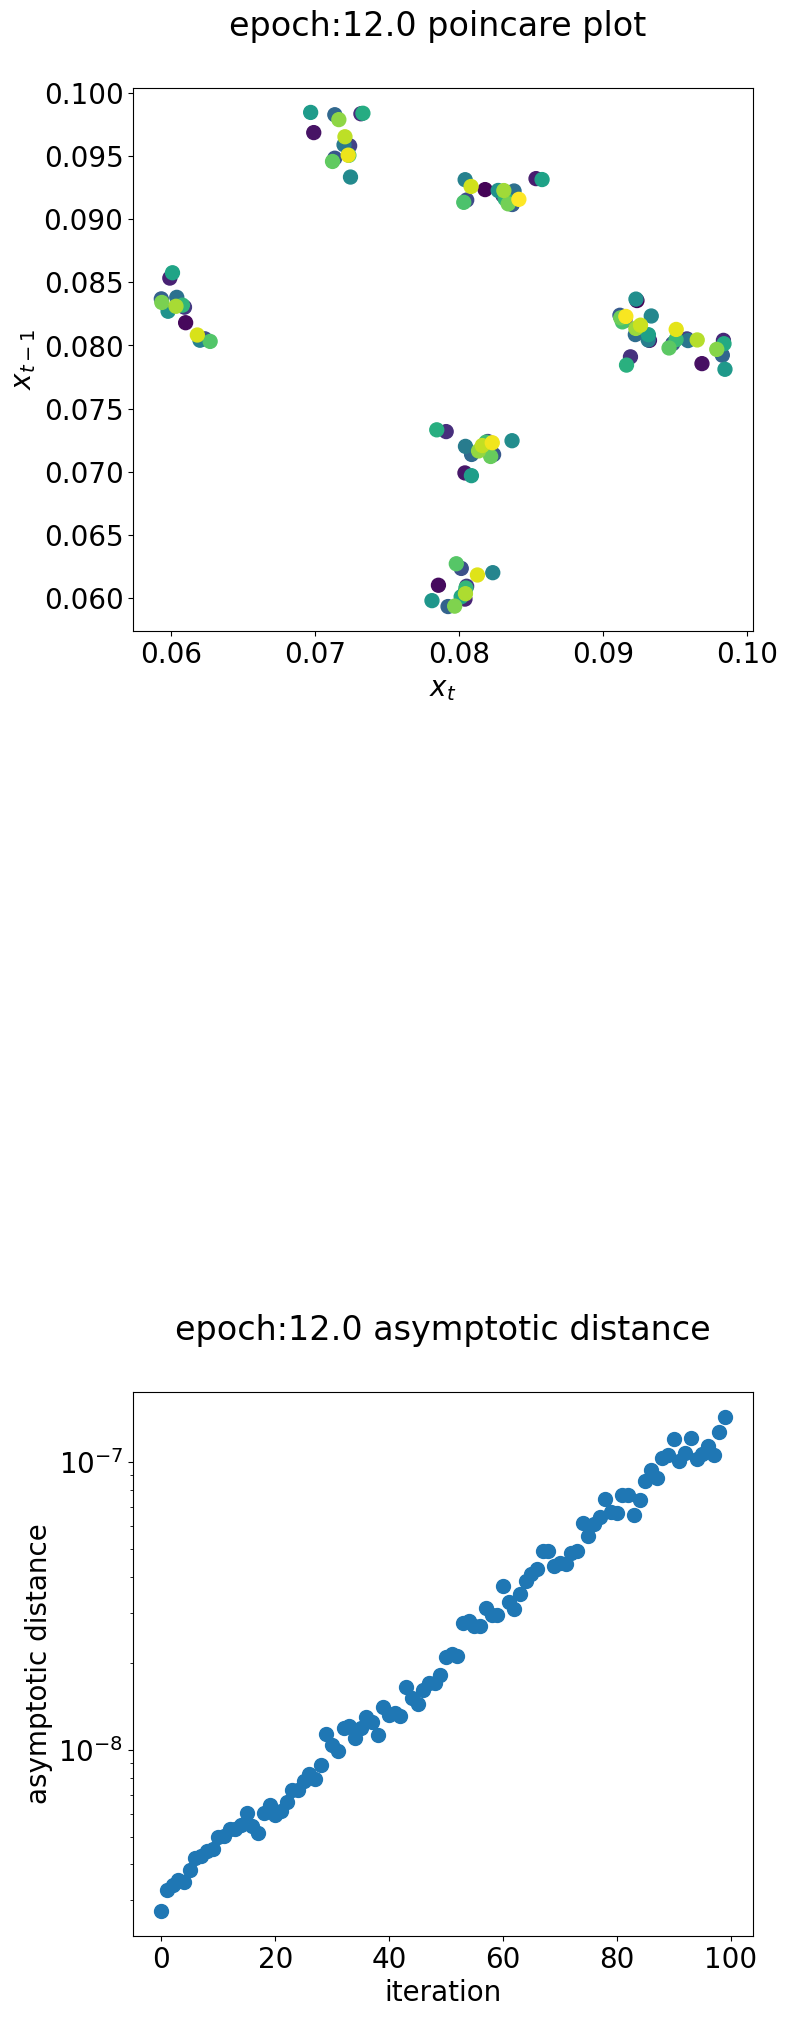

epoch:13 Train loss:0.34696966 train accuracy:92.542%,test accuracy:89.080000%
percentage of chaos: 0.9
percentage of convergent: 0.0
2.4404769056928994e-09


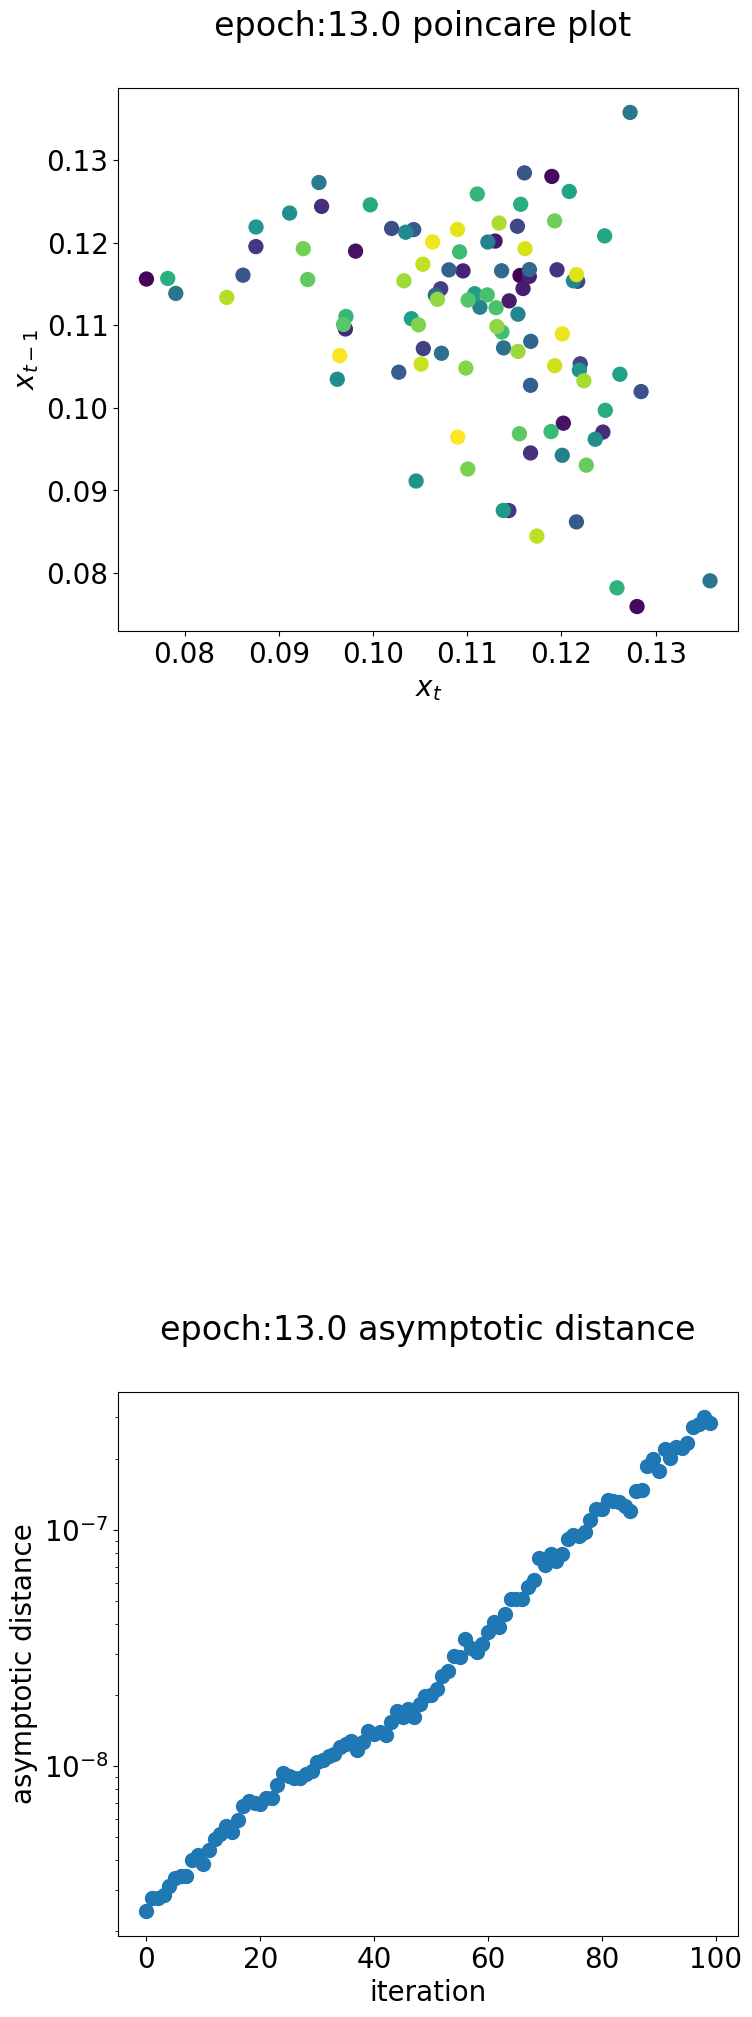

epoch:14 Train loss:0.31169684 train accuracy:92.778%,test accuracy:89.220000%
percentage of chaos: 0.95
percentage of convergent: 0.0
2.7672936944220695e-09


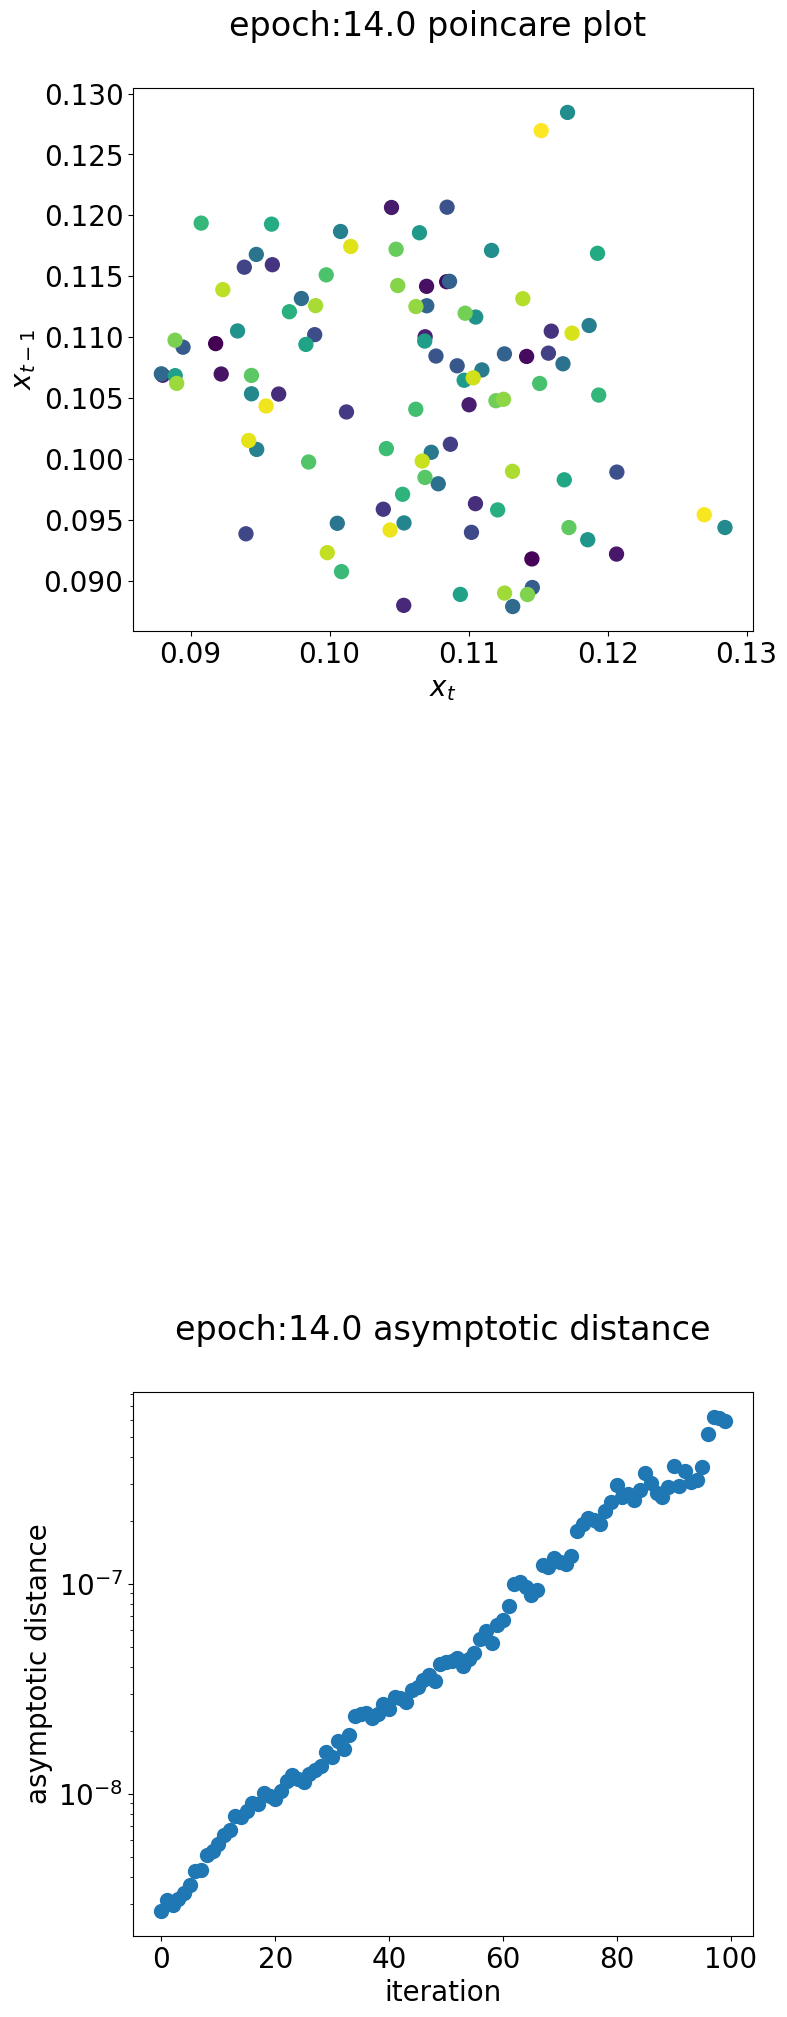

epoch:15 Train loss:0.27249852 train accuracy:93.187%,test accuracy:89.330000%
percentage of chaos: 1.0
percentage of convergent: 0.0
2.9180469502578026e-09


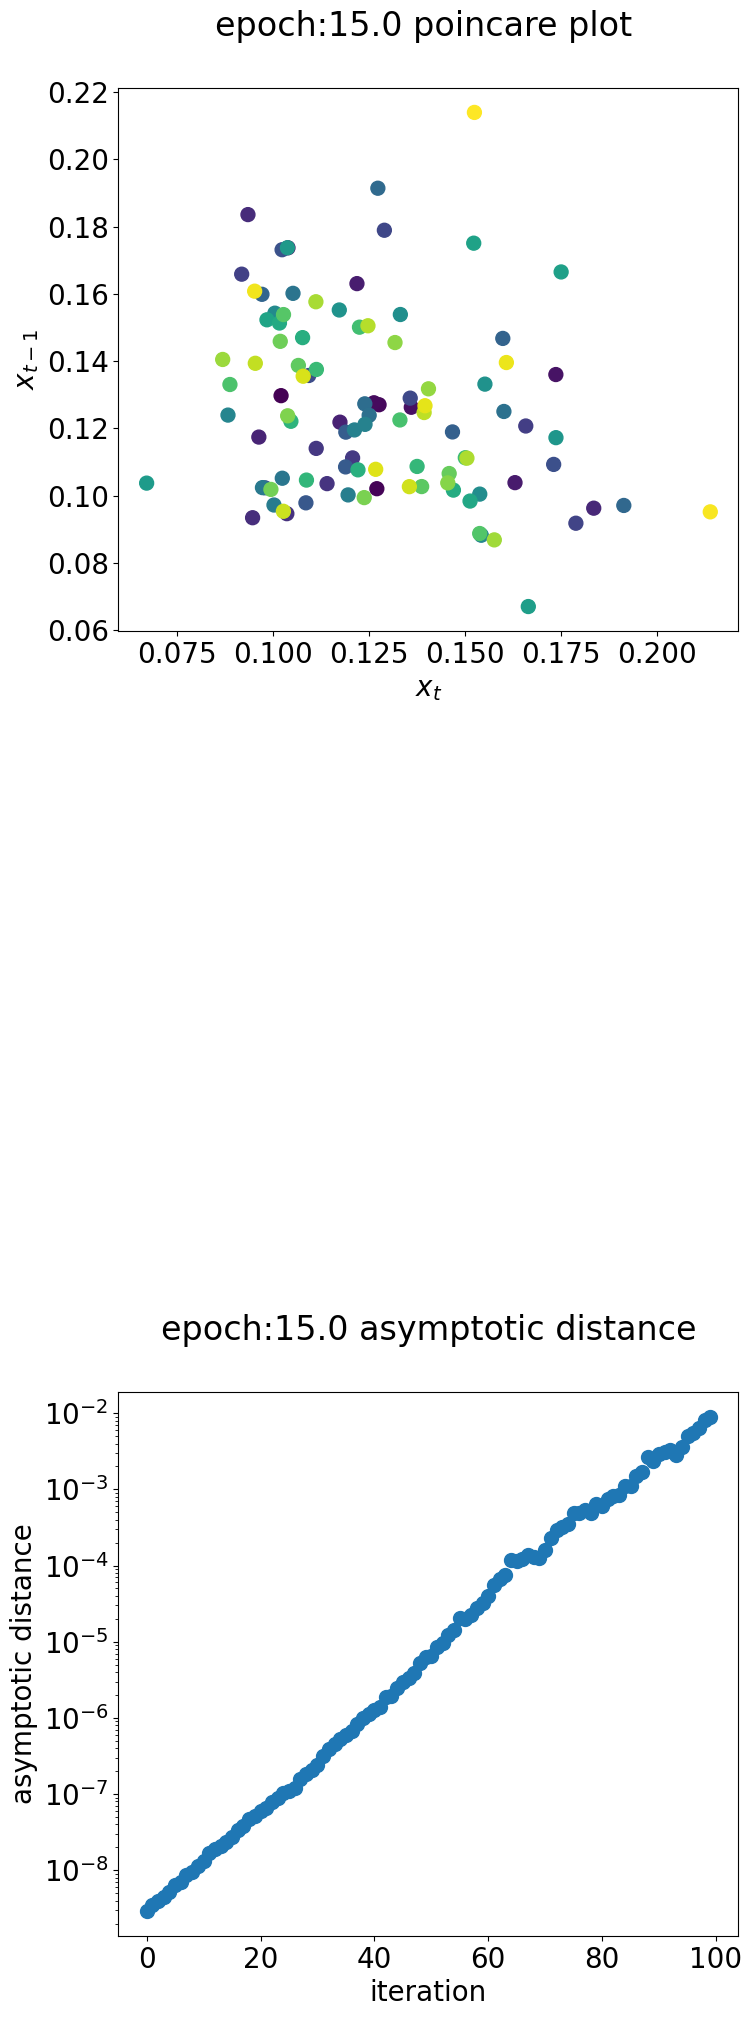

epoch:16 Train loss:0.40178989 train accuracy:93.390%,test accuracy:89.160000%
percentage of chaos: 1.0
percentage of convergent: 0.0
2.9295318006172294e-09


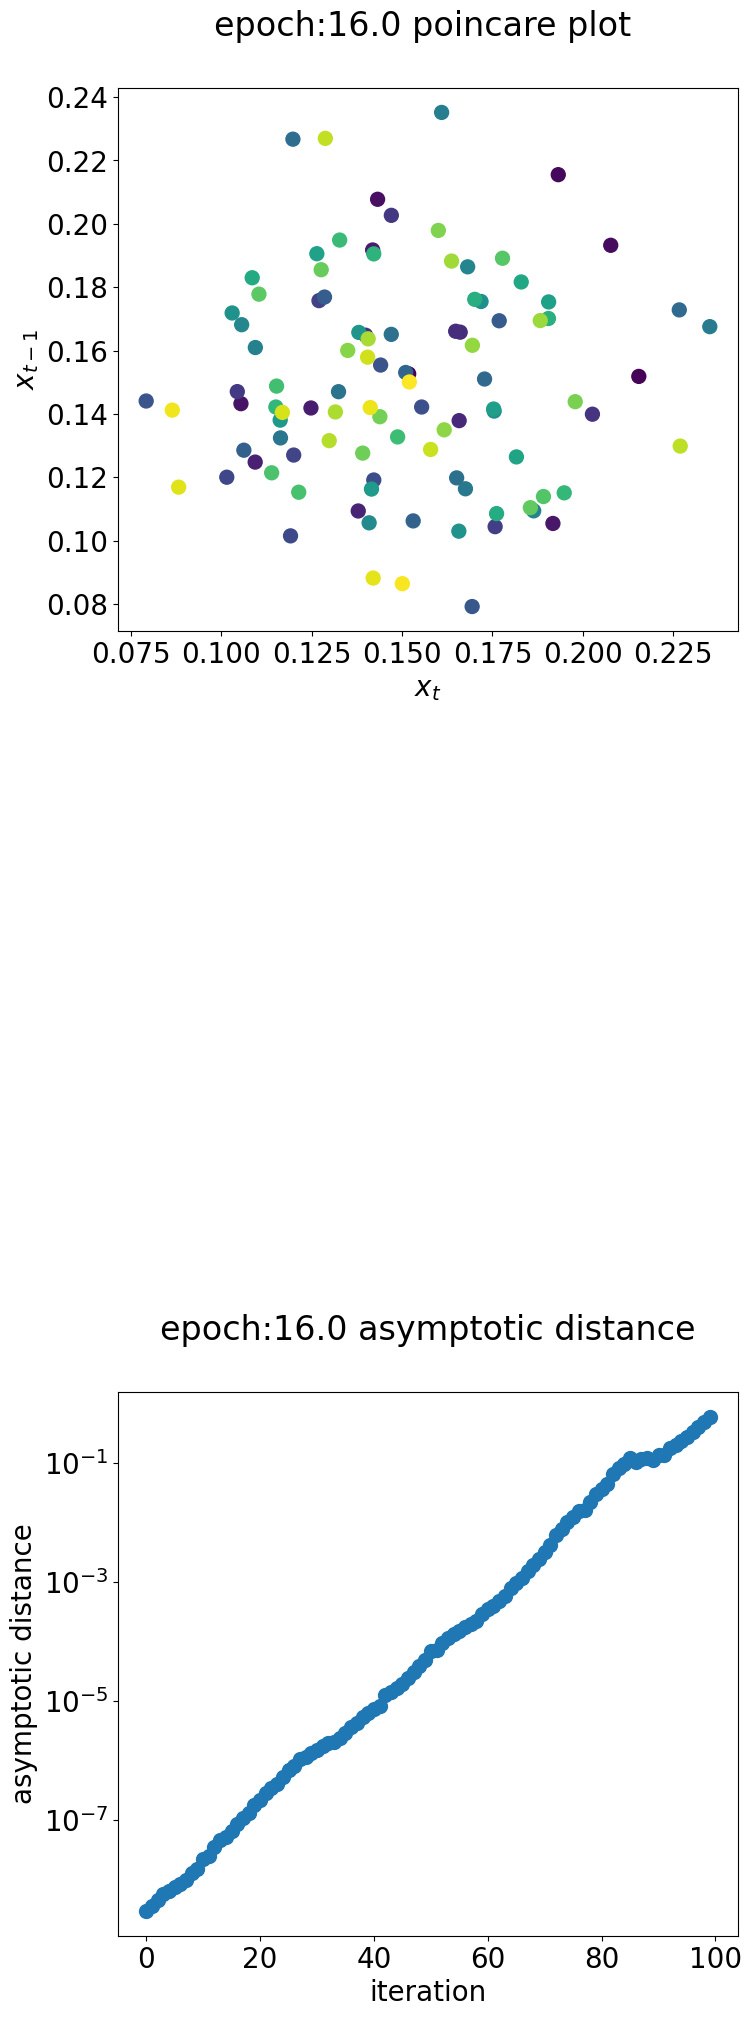

epoch:17 Train loss:0.34864352 train accuracy:93.463%,test accuracy:89.760000%
percentage of chaos: 1.0
percentage of convergent: 0.0
3.0706315672518243e-09


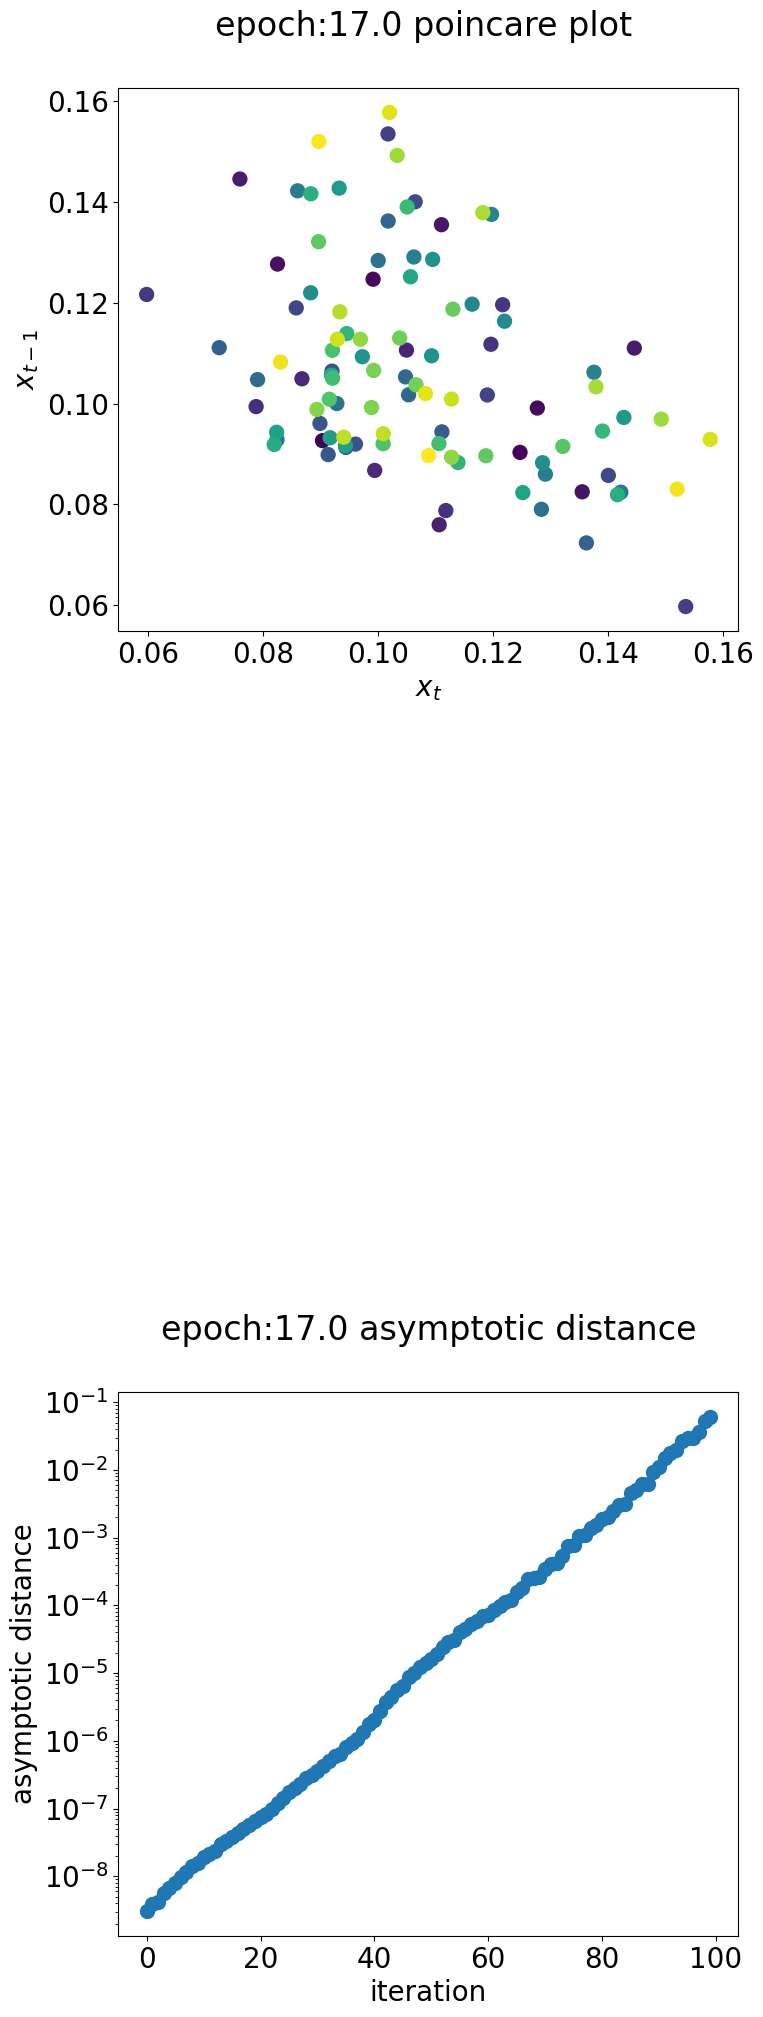

epoch:18 Train loss:0.38993787 train accuracy:93.862%,test accuracy:89.340000%
percentage of chaos: 1.0
percentage of convergent: 0.0
3.073228748834958e-09


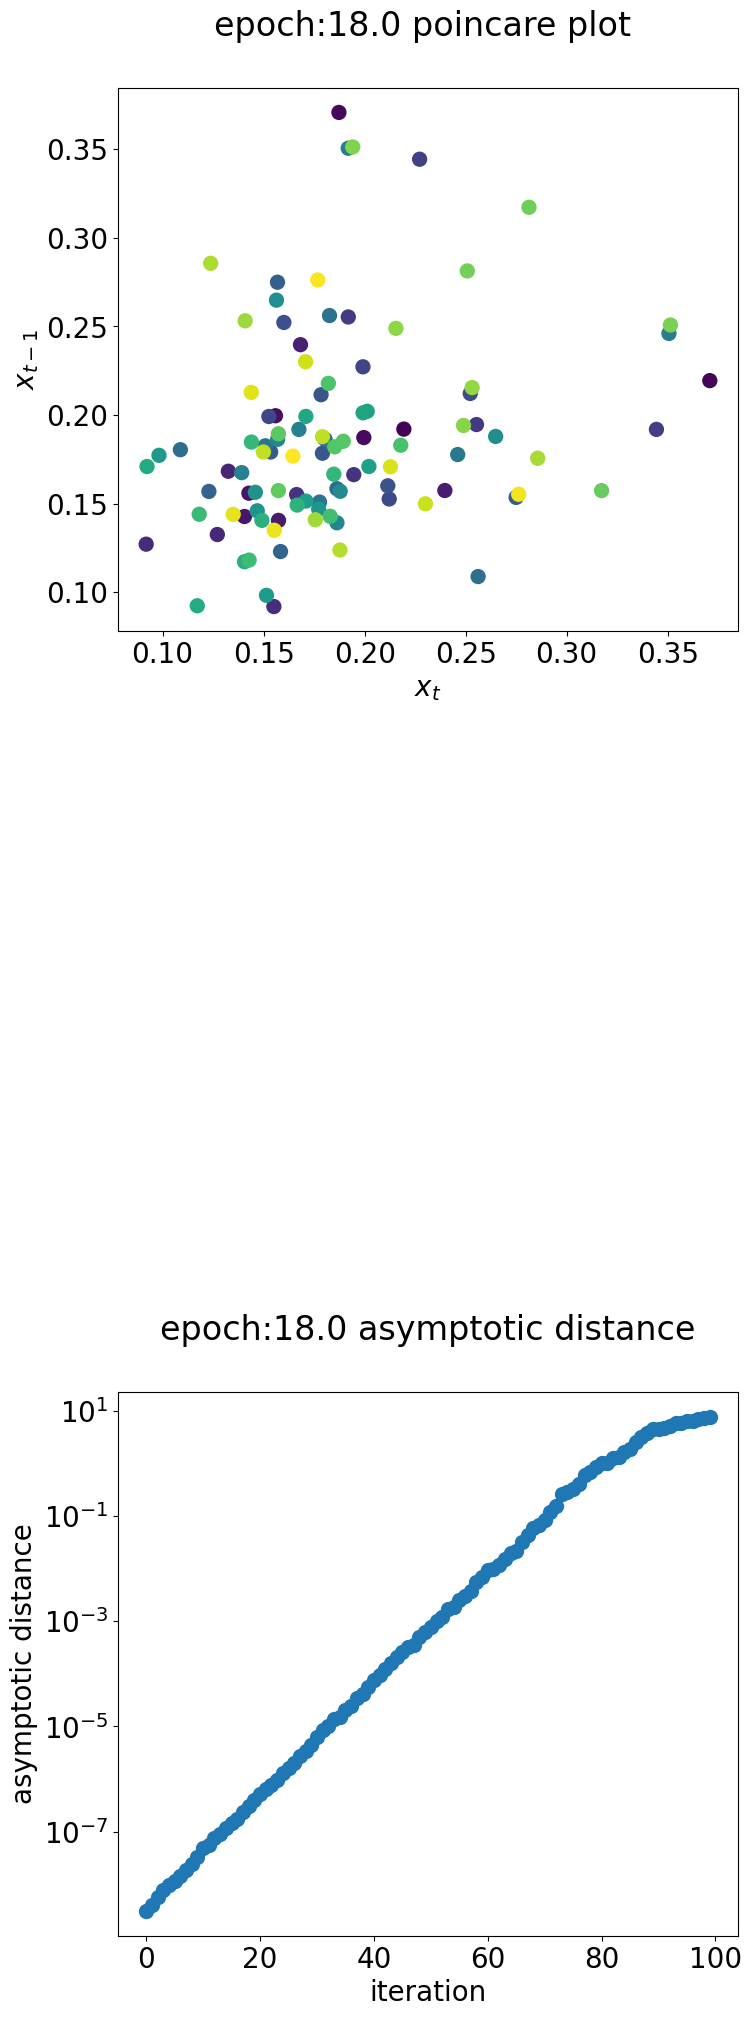

epoch:19 Train loss:0.36013620 train accuracy:94.052%,test accuracy:89.670000%
percentage of chaos: 1.0
percentage of convergent: 0.0
2.9771809357590743e-09


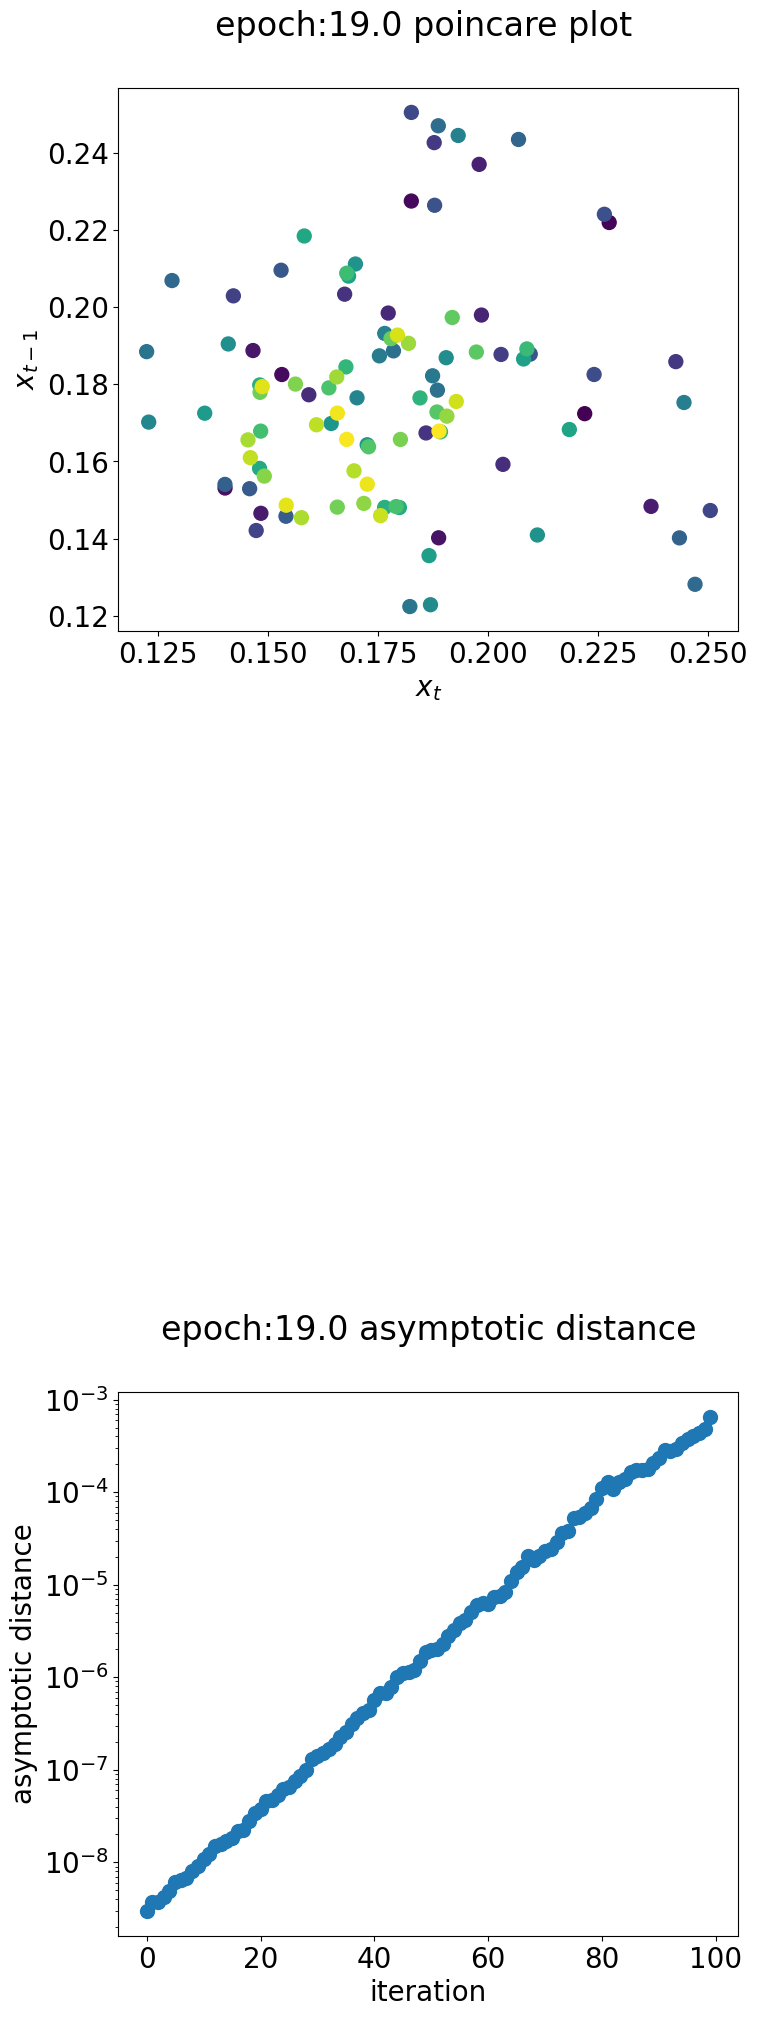

epoch:20 Train loss:0.38220112 train accuracy:94.347%,test accuracy:89.270000%
percentage of chaos: 1.0
percentage of convergent: 0.0
3.5273127953608075e-09


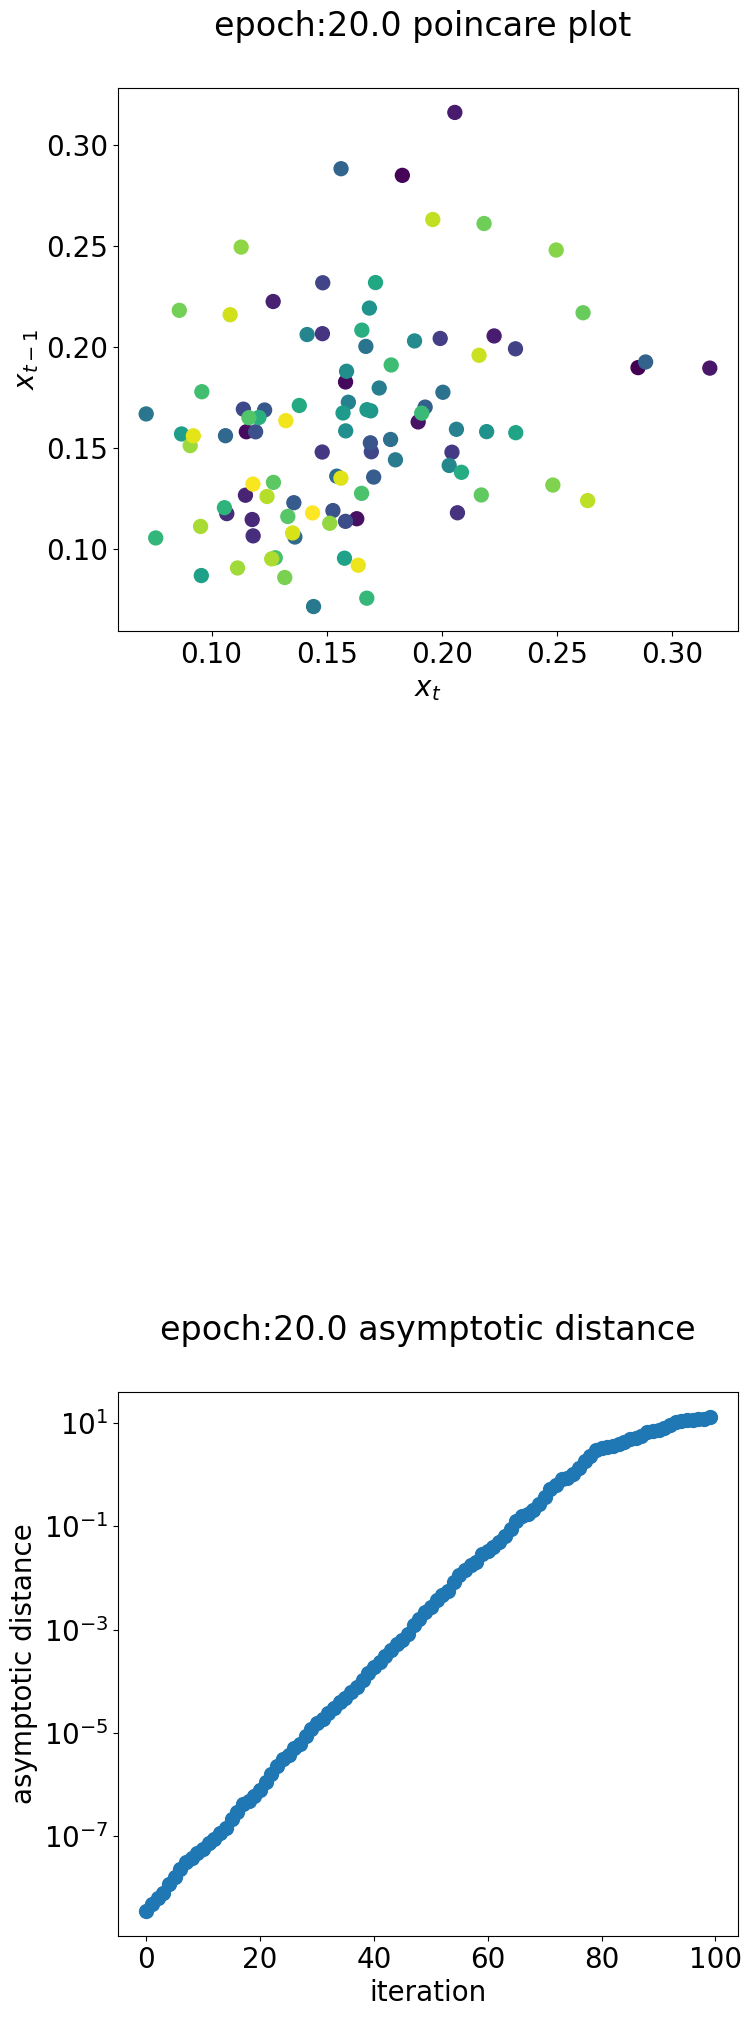

epoch:21 Train loss:0.52503620 train accuracy:94.422%,test accuracy:89.190000%
percentage of chaos: 1.0
percentage of convergent: 0.0
3.574390331997909e-09


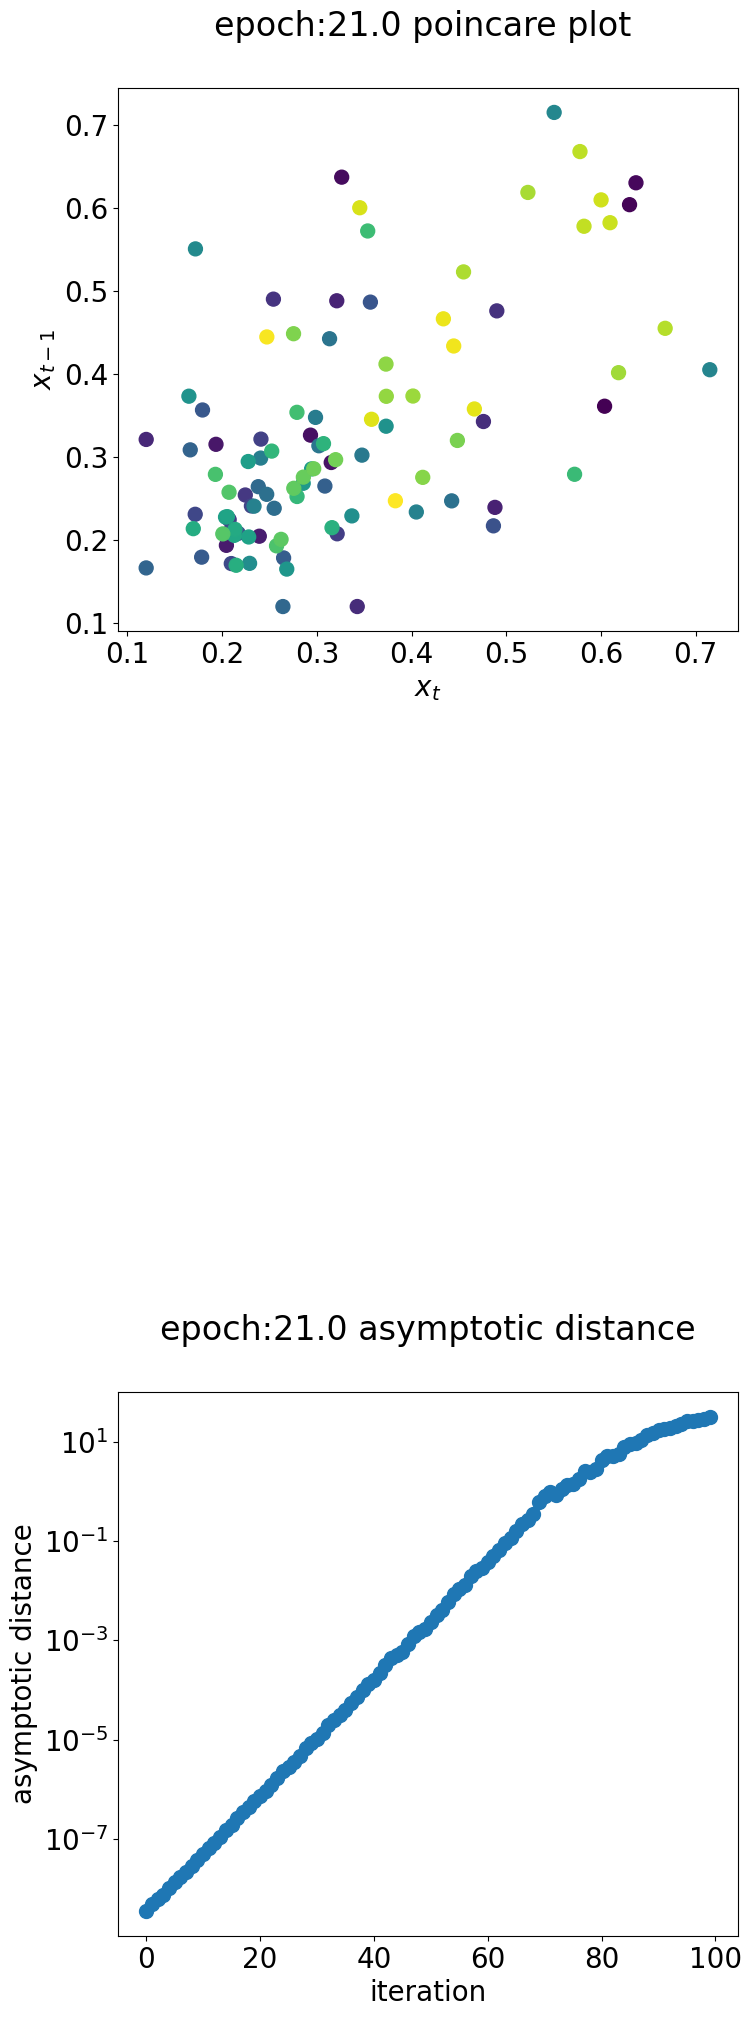

epoch:22 Train loss:0.28346195 train accuracy:94.602%,test accuracy:89.170000%
percentage of chaos: 1.0
percentage of convergent: 0.0
3.2776958941040604e-09


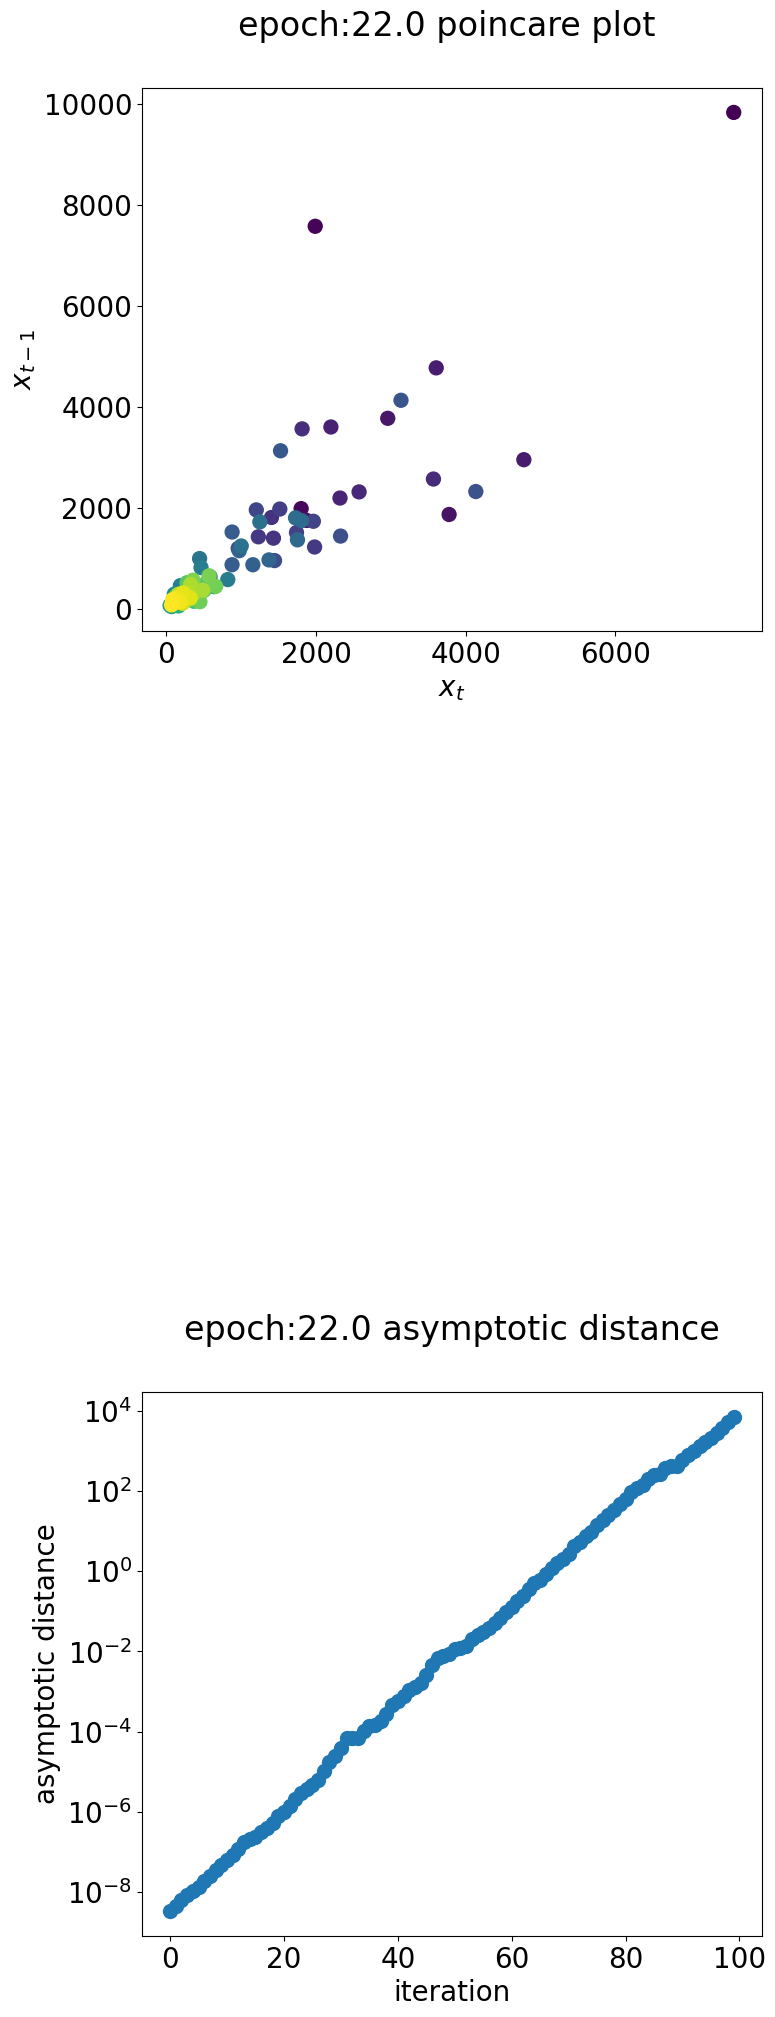

epoch:23 Train loss:0.47170674 train accuracy:94.857%,test accuracy:89.730000%
percentage of chaos: 0.0
percentage of convergent: 0.0
0.0


/tmp/ipykernel_6932/1436160901.py:97: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


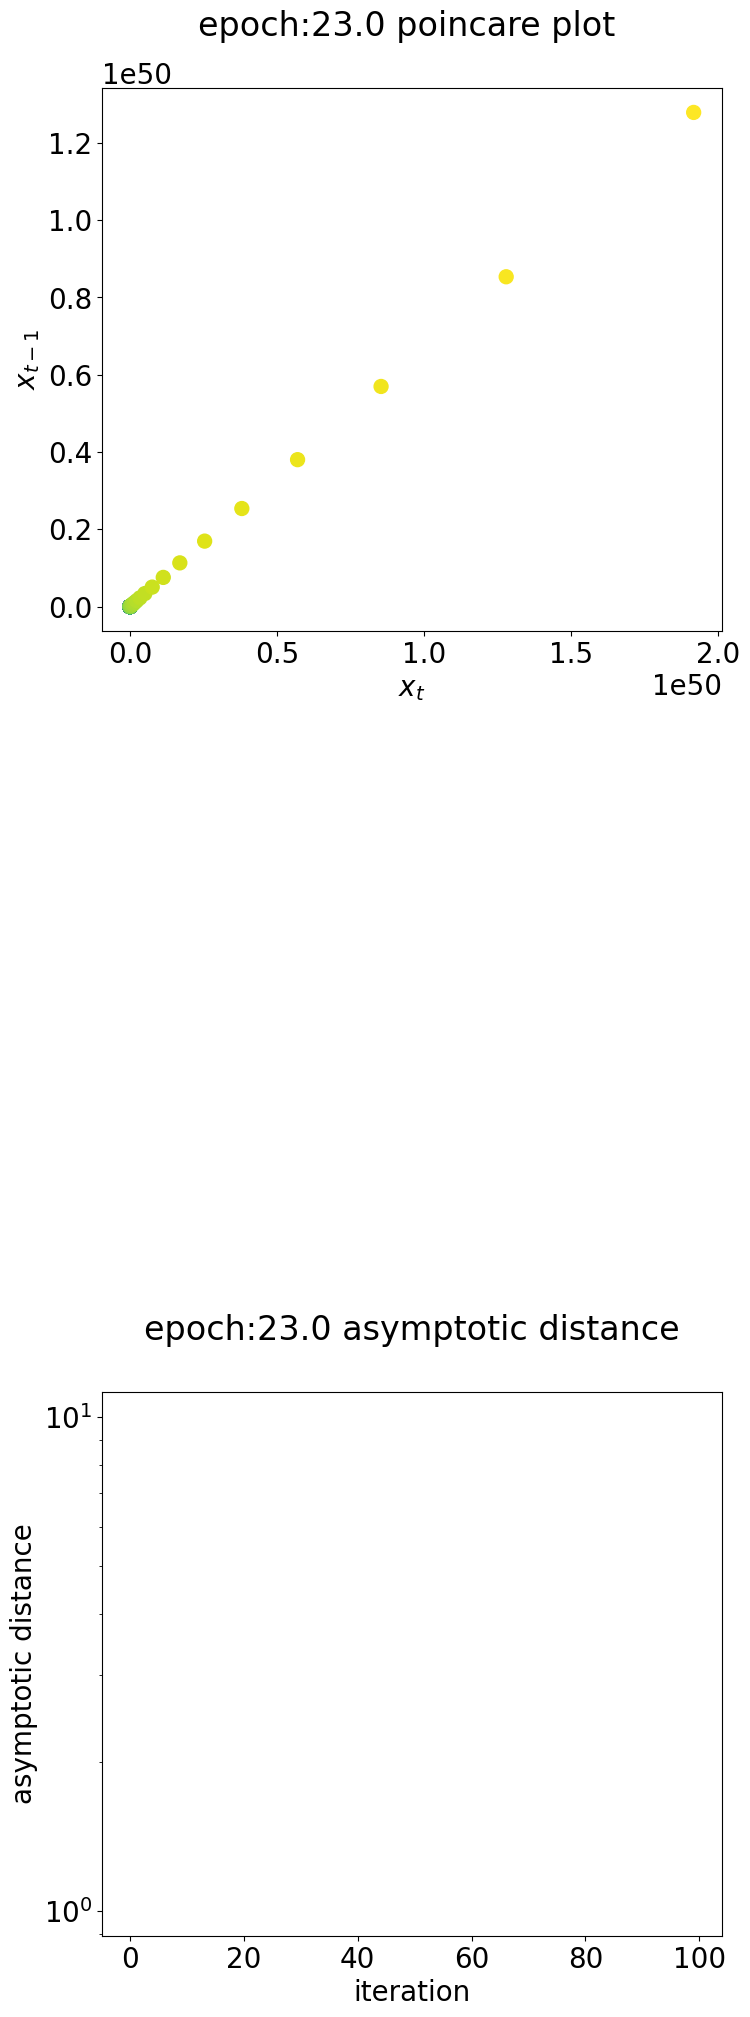

epoch:24 Train loss:0.36846376 train accuracy:95.087%,test accuracy:89.330000%
percentage of chaos: 0.0
percentage of convergent: 0.0
0.0


/tmp/ipykernel_6932/1436160901.py:97: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


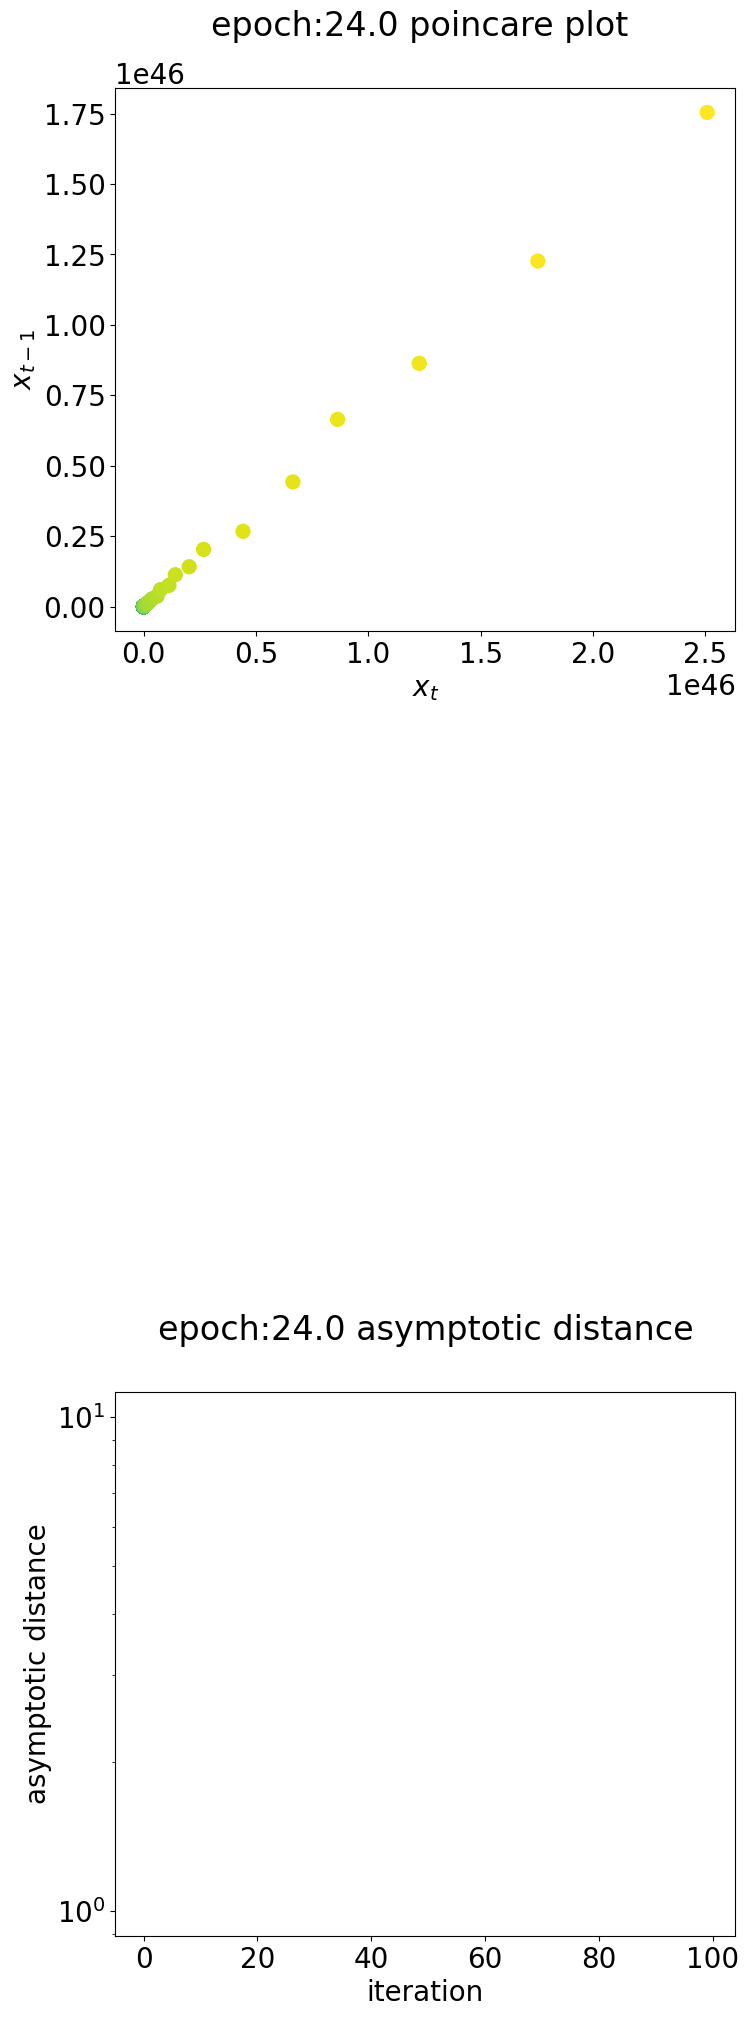

epoch:25 Train loss:0.34139372 train accuracy:95.213%,test accuracy:89.700000%
percentage of chaos: 0.0
percentage of convergent: 0.0
0.0


/tmp/ipykernel_6932/1436160901.py:97: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


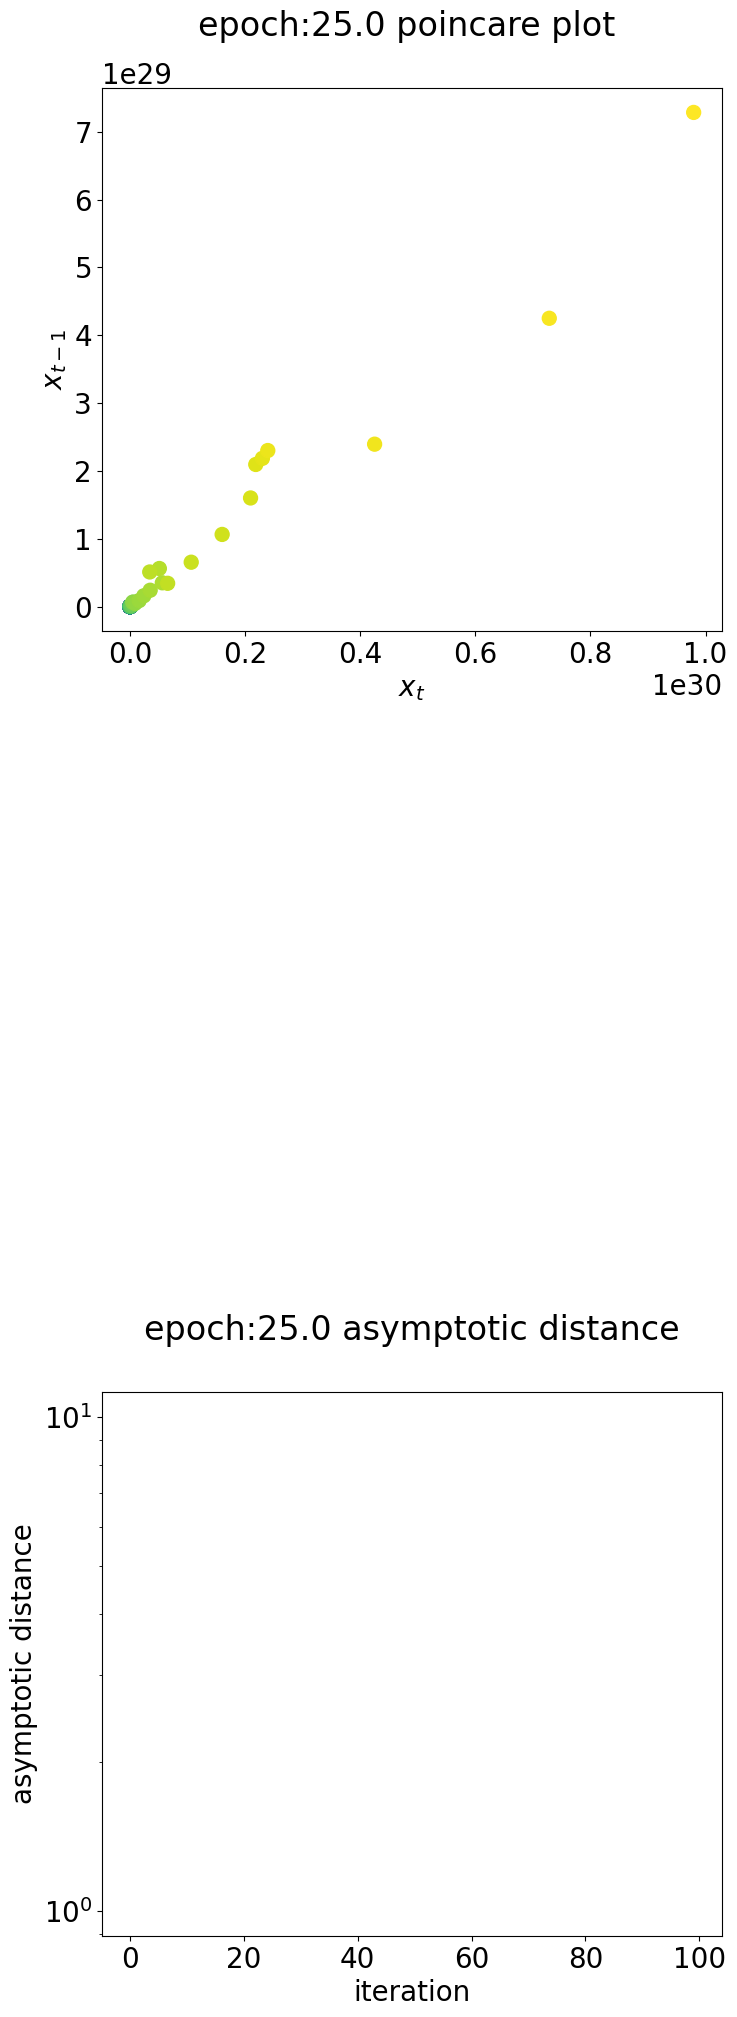

epoch:26 Train loss:0.57045598 train accuracy:95.345%,test accuracy:89.180000%
percentage of chaos: 0.05
percentage of convergent: 0.0
1.8684568486864564e-09


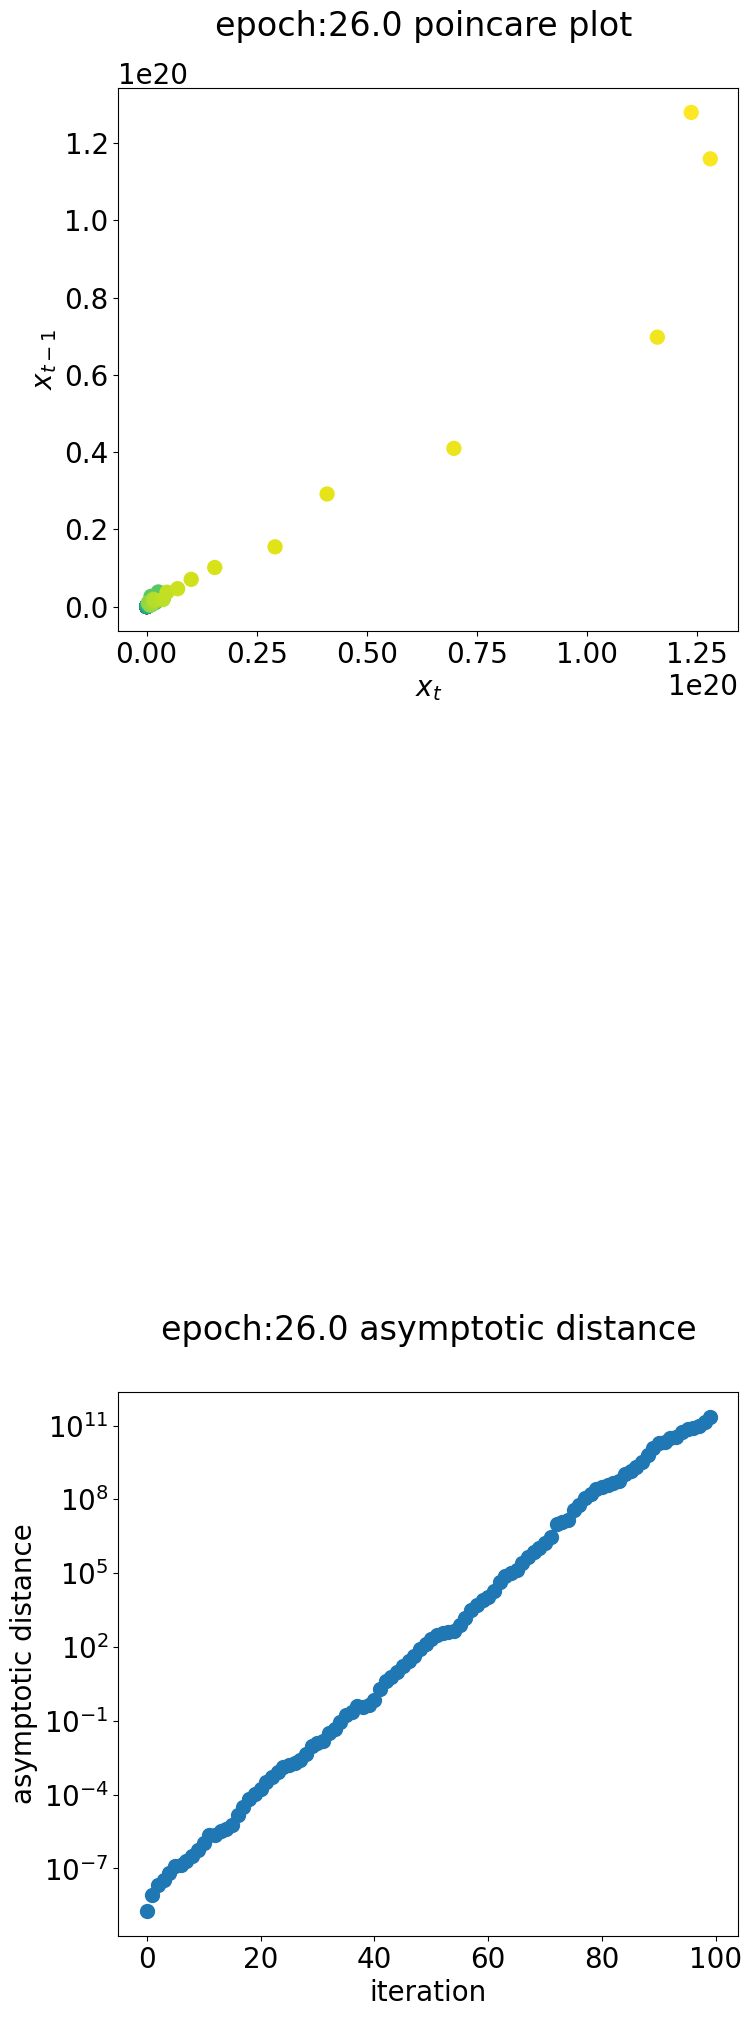

epoch:27 Train loss:0.46361684 train accuracy:95.425%,test accuracy:89.270000%
percentage of chaos: 1.0
percentage of convergent: 0.0
5.102256218759569e-09


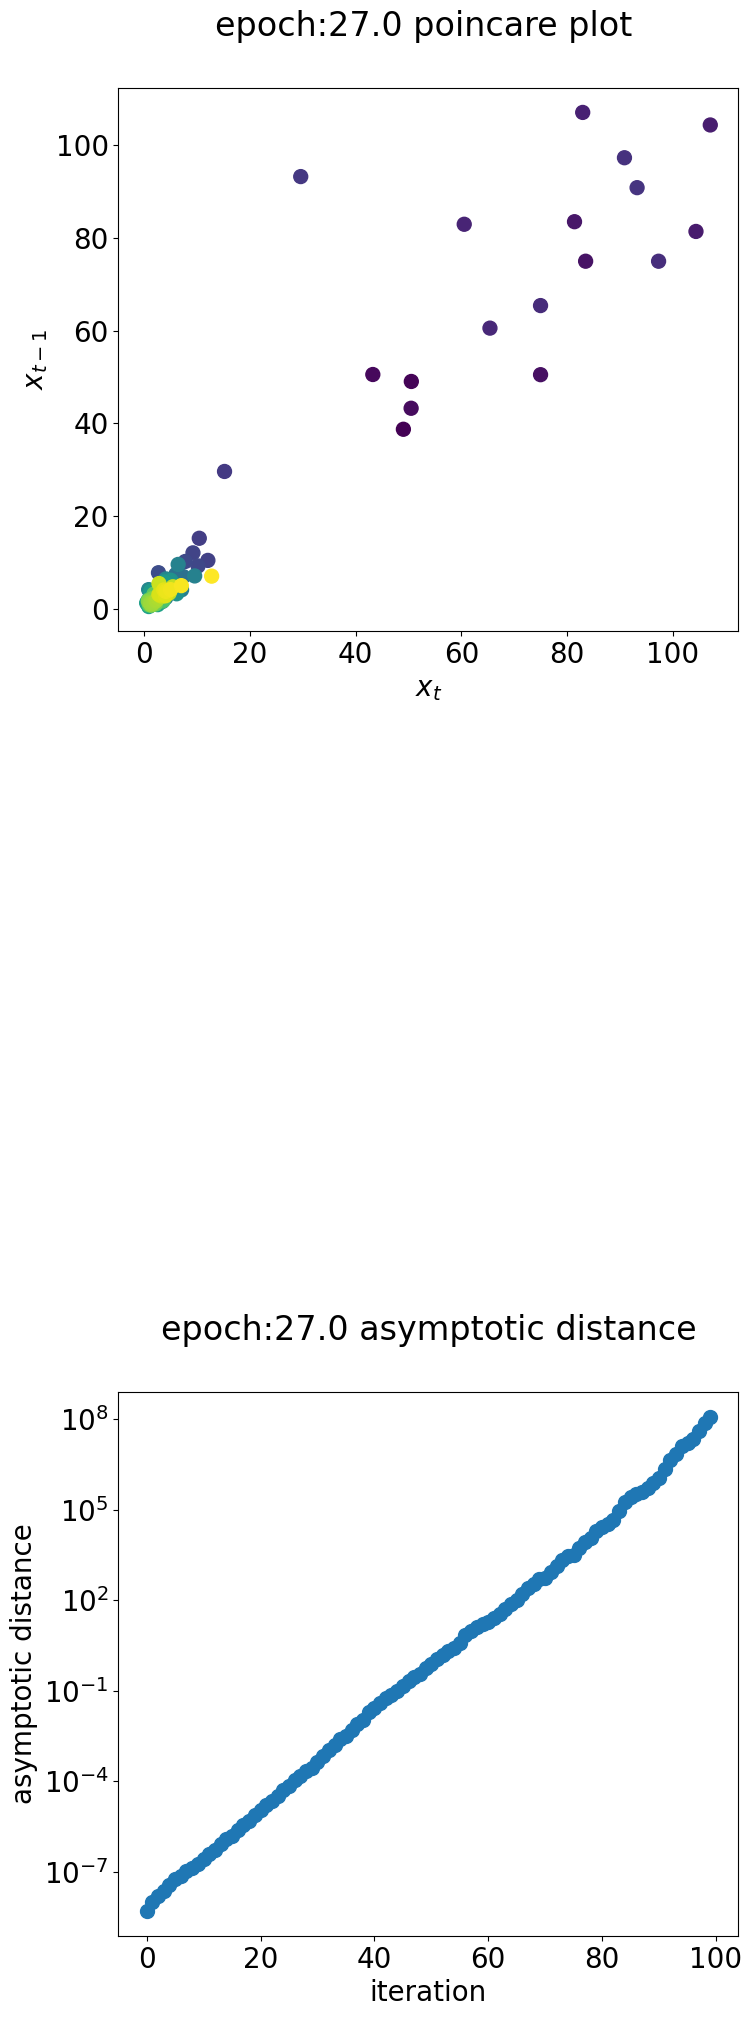

epoch:28 Train loss:0.51637984 train accuracy:95.860%,test accuracy:89.740000%
percentage of chaos: 0.8
percentage of convergent: 0.0
1.0756695377581841e-08


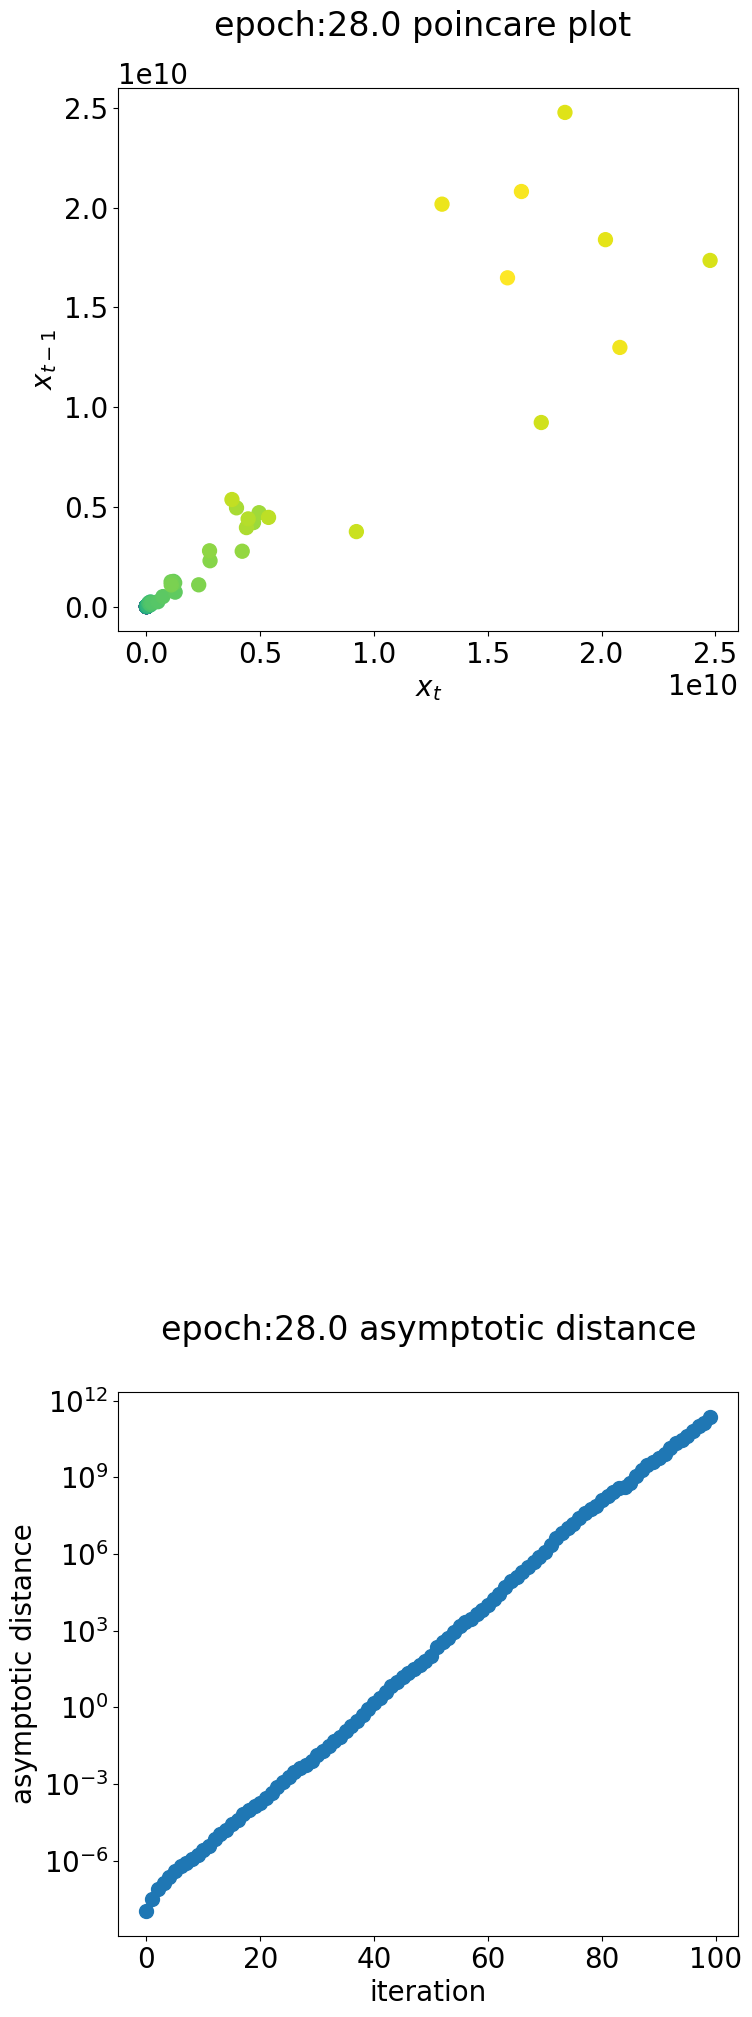

epoch:29 Train loss:0.52496371 train accuracy:95.810%,test accuracy:90.210000%
percentage of chaos: 0.0
percentage of convergent: 0.0
0.0


/tmp/ipykernel_6932/1436160901.py:97: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


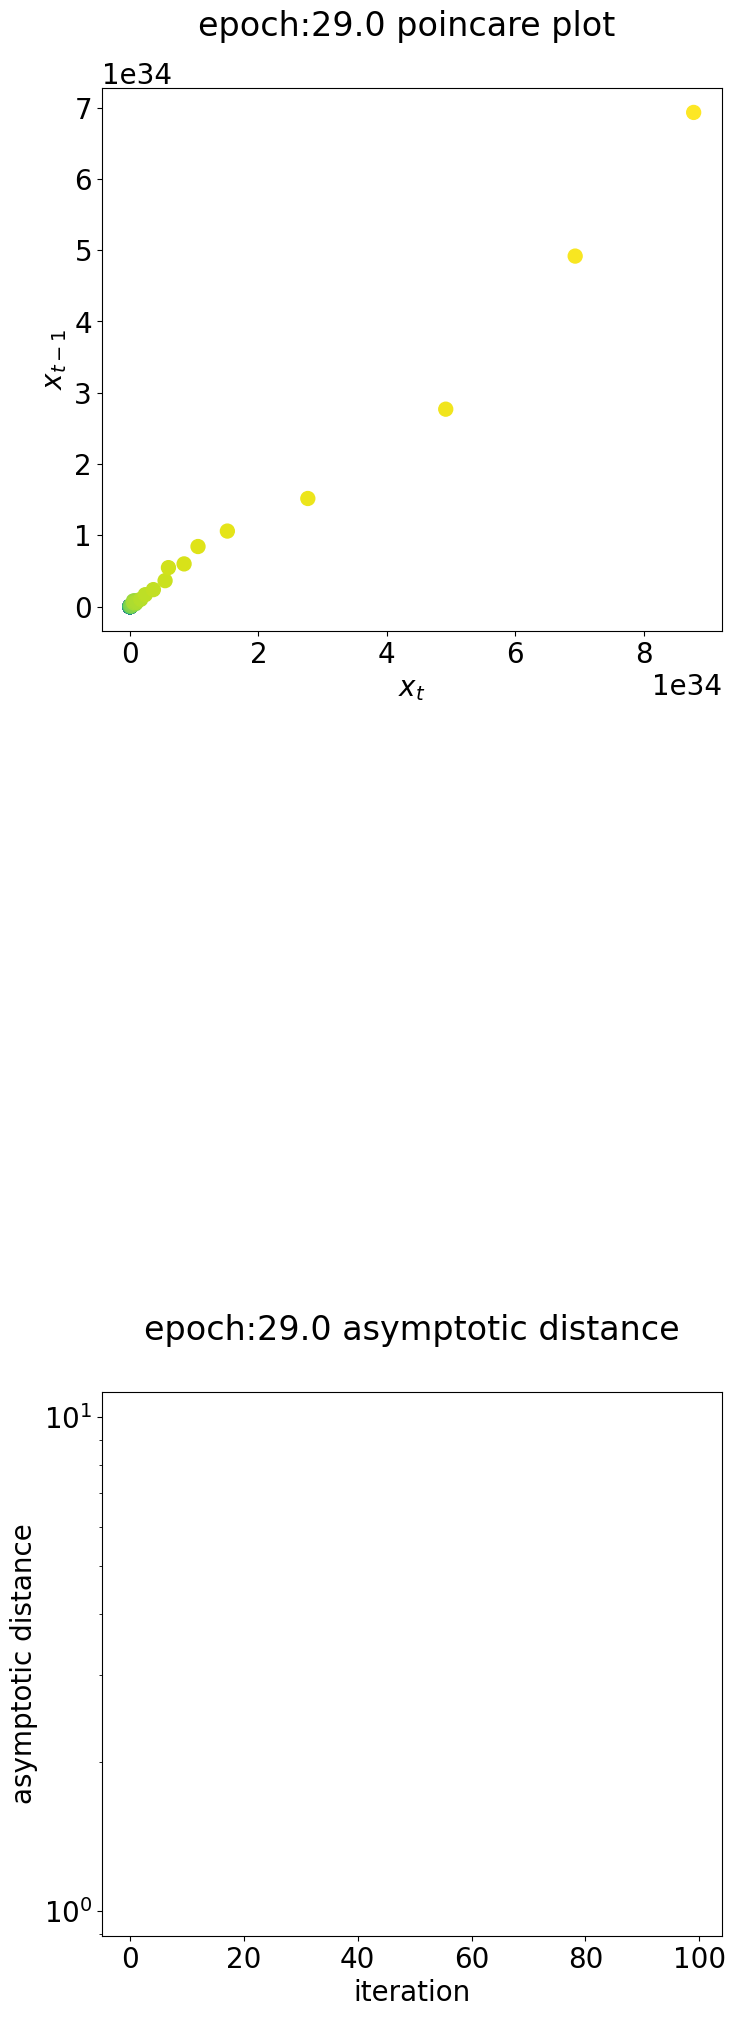

epoch:30 Train loss:0.51944733 train accuracy:96.025%,test accuracy:89.670000%
percentage of chaos: 0.65
percentage of convergent: 0.0
1.0743834533136728e-08


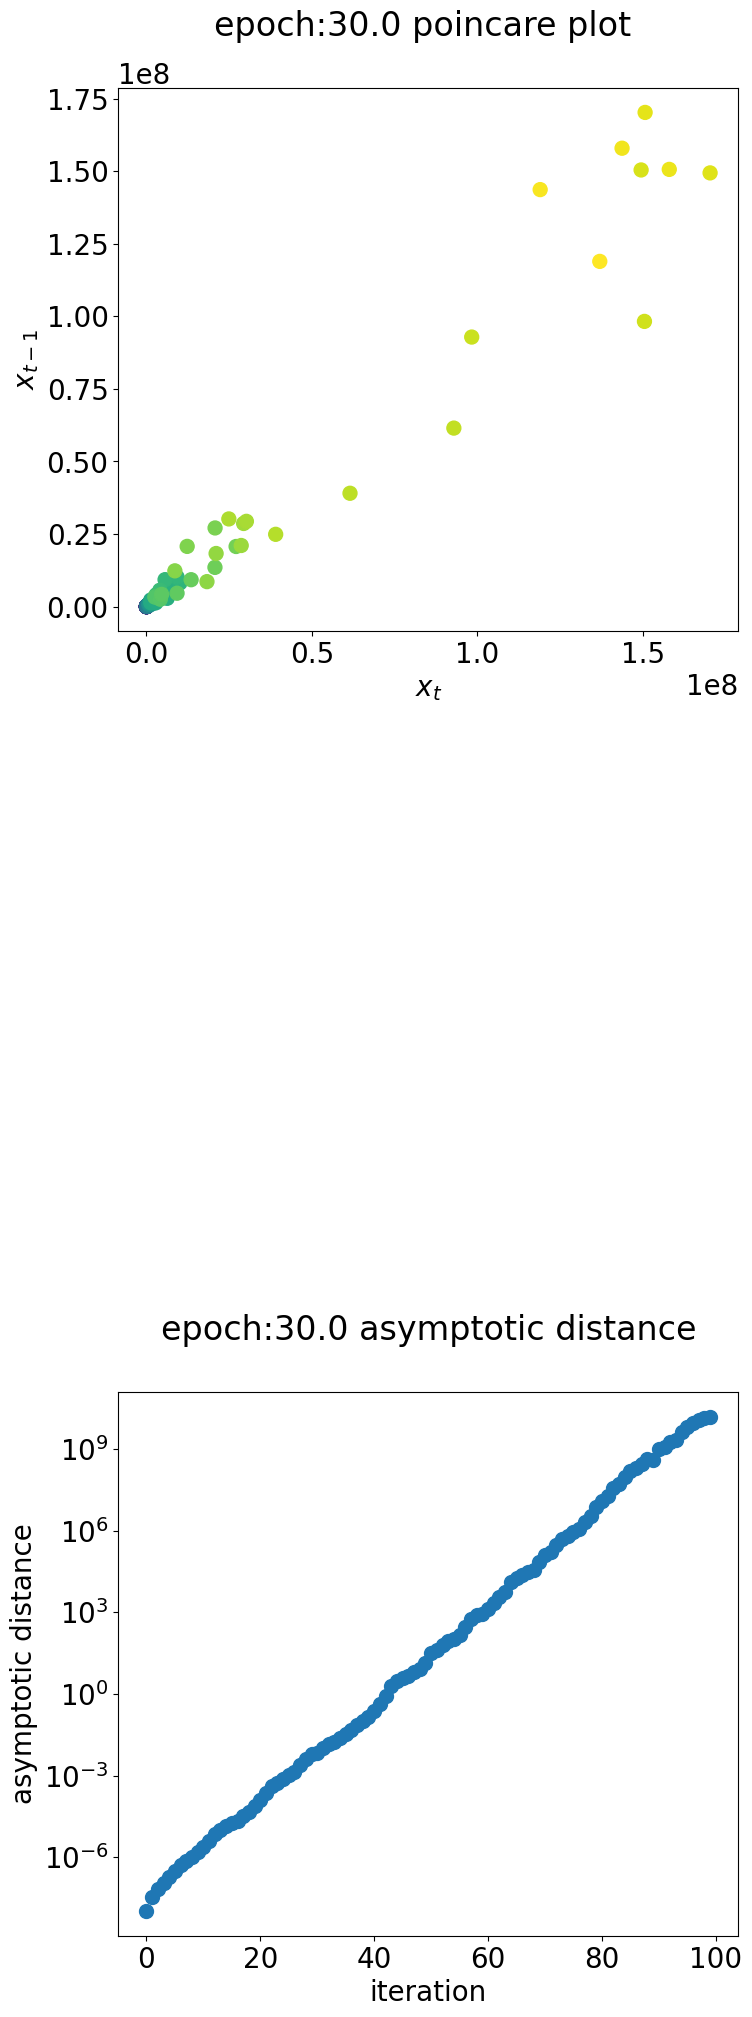

runtime: 14476.255330324173


In [12]:
import torch
import time
import copy
num_epochs = 30
count = 0
#model_clone=Feedforward(784,784,2)
#model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
print("here")
start=time.time()
jacobian=[]
average_jacobian=[]
spectral_radiuses=[]
asymptotic_dist=[]
chao=[]
for i in range(1):
    model = Feedforward(784,784,2)
    criterion =  nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Lists for visualization of loss and accuracy 
    train_losses=[]
    test_losses=[]
    train_correct=[]
    test_correct=[]


    for epoch in range(num_epochs):
        trn_corr=0
        tst_corr=0
        for b,(x_train,y_train) in enumerate(train_loader):
            b+=1
            input_image=x_train.view(100,-1)
            y_pred=model(x_train.view(100,-1))
            loss=criterion(y_pred,y_train)
            predicted=torch.max(y_pred.data,1)[1]
            batch_corr=(predicted==y_train).sum()
            trn_corr+=batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
        #if b%600==0:

            #print(f'epoch:{epoch:2} batch:{b:4}[{100*b:6}/60000] Train loss:{loss.item():10.8f} train accuracy:{trn_corr.item()*100/60000:.3f}% ')
        train_losses.append(loss.item())
        train_correct.append(trn_corr)
    
        with torch.no_grad():
            for b,(x_test,y_test) in enumerate(test_loader):
                y_val=model(x_test.view(100,-1))
                predicted=torch.max(y_val.data,1)[1]
                tst_corr+=(predicted==y_test).sum()
                #if b%100==0:
        #print(f'epoch:{epoch:2} batch:{b:4}[{100*b:6}/60000] Train loss:{loss.item():10.8f} train accuracy:{trn_corr.item()*100/60000:.3f}%,test accuracy:{test_correct[-1].item()*100/10000:3f}%')
                loss=criterion(y_val,y_test)
        test_losses.append(loss.item())
        test_correct.append(tst_corr)
        print(f'epoch:{epoch+1:2} Train loss:{loss.item():10.8f} train accuracy:{trn_corr.item()*100/60000:.3f}%,test accuracy:{test_correct[-1].item()*100/10000:3f}%')
         
        x_train=torch.mean(model.init(),dim=0)

        #y_train=torch.mean(model.final(),dim=0)

        #print(x_train)               
        model_clone=Feedforward(784,784,2)
        model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
        #x_train=model.init()
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        perturbed_inputs=add_noise(x_train,perturbation_strength)
        distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*np.sqrt(input_size))
        print("percentage of chaos:",chaos) 
        print("percentage of convergent:",divergent/100)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        print(distance[0])
        chao.append(chaos)
        #diverge.append(divergent/100)
        fig = plt.figure(figsize=(8,24))

        plt.subplot(3, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)

        plt.subplot(3, 1, 3)
        plt.scatter(range(no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance")
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1),y=1.08)
        plt.savefig("result{:.1f}.jpg".format(epoch+1))
        plt.show()
   
        if epoch==epochs-1:
            for value in model.parameters():
                #print(key)
                plots=torch.flatten(value).cpu().detach().numpy()
                plt.hist(plots, density=True, bins='auto', histtype='stepfilled',cumulative=-1)
                #plt.title("model "+str(key)+"plot")
                plt.savefig("model "+str(init)+"plot.jpg")
                np.savetxt("fianl weight mlp"+str(init)+".txt",value)
                plt.show()
                init+=1
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
    end=time.time()
    print("runtime:",end-start)

In [ ]:
labels="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength)
print(chao)
#print(diverge)
font = {'size'   : 16}
plt.rc('font', **font)

x=np.arange(1,101)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/20")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.title("fraction of image in chaos for reproduced result",y=1.08)
plt.savefig("percentage of image in chaos reproduced result.jpg",bbox_inches = 'tight')

np.savetxt("percentage of chaos reproduced result.txt",chao)
plt.show()

plt.scatter(x,y=asymptotic_dist)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch")
plt.title("asymptotic distance")
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
plt.savefig("asymptotic distance reproduced result.jpg")

plt.show()
np.savetxt("asymptotic distance reproduced result.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

print("average jacobian")
plt.scatter(x,y=average_jacobian)
plt.ylabel("average_jacobian")
plt.xlabel("epoch")
plt.yscale("log")
plt.title("average_jacobian")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
plt.savefig("average_jacobian reproduced result.jpg")
np.savetxt("average jacobian reproduced result.txt",average_jacobian)
plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")
#np.savetxt("spectral radius.txt",spectral_radiuses)
#plt.show()
test_loss=[]
train_loss=[]
for i in range(len(test_losses)):
    test_loss.append(test_losses[i].item())
    train_loss.append(train_losses[i].item())
print("loss function")
plt.plot(test_loss,label="validation loss")
plt.plot(train_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
#plt.yscale("log")
plt.savefig("loss function reproduced result.jpg")
np.savetxt("loss_function reproduced result.txt",(test_loss,train_loss))
plt.show()